In [160]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy.api as sc

import scipy
scipy.__version__

'1.2.2'

In [15]:
path='/Users/derekbogdanoff/projects/XYZeq/data/20190917/'

In [16]:
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file = './write/results.h5ad'

#sc.settings = True

##load the data
adata=sc.read(path + 'matrix_mergedIntron.mtx', cache=False).T





# ##name the genes
adata.var_names = [gene.strip() for gene in open(path + 'genes.tsv', 'r')]


# ##name the cells
adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.17.2 scipy==1.2.2 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
adata.var_names_make_unique()

In [18]:
adata=adata[adata.obs_names.str.contains('L20C1')]

In [19]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=500)#300
sc.pp.filter_cells(adata, min_genes=100)

#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)



Trying to set attribute `.obs` of view, making a copy.


filtered out 18293 cells that have less than 500 counts
filtered out 3 cells that have less than 100 genes expressed
filtered out 71226 genes that are detected in less than 2 cells


Index(['L20C1_P1A01F.GACGACACGCTCACTC', 'L20C1_P1A03F.CTTCGCGCTGTCCATC',
       'L20C1_P1A06F.GATCACGTAGGAGCCG', 'L20C1_P1A06F.GGCACTTATCCTGGTG',
       'L20C1_P1A11F.GGTGCCTGATGCCACT', 'L20C1_P1B01F.ATCTGGAAGGACATCC',
       'L20C1_P1B02F.GCTACGTCGCATAGGT', 'L20C1_P1B05F.CACTAAGTACTTCCTC',
       'L20C1_P1B06F.GCTCATCATACTCACT', 'L20C1_P1B07F.TAGTCTCCGACCTGCT',
       ...
       'L20C1_P4G10F.AGAGTCAATGCCATGC', 'L20C1_P4H01F.CTGTGGACCTGGTTGG',
       'L20C1_P4H01F.TCCACCGTATGCGCTG', 'L20C1_P4H02F.CGGATGCGAGGACTTC',
       'L20C1_P4H04F.TCCTCAAGCAAGCACT', 'L20C1_P4H05F.CTCCGTTCTCTATTCA',
       'L20C1_P4H06F.CTACGTCTCCAGCGCA', 'L20C1_P4H06F.GTACCTACTCTAGACA',
       'L20C1_P4H07F.TCCACTGGAGTGTCGC', 'L20C1_P4H11F.GGTGCCTGATGCCACT'],
      dtype='object', length=239)

In [20]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Itgam')]
adata=adata[:, spec_filter]

In [21]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Smim20')]
adata=adata[:, spec_filter]

In [22]:
spec_filter= [name for name in adata.var_names if not name.startswith('hg19_RP11-323I15.5')]
adata=adata[:, spec_filter]

In [23]:
##filter out outliers

adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito'] < 1, :]


In [24]:
##create raw data file

adata.raw = sc.pp.log1p(adata, copy=True)




In [25]:
##normalize counts per cell to 10K each 

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)



In [26]:
print(adata.X.sum(axis=1))

[[10000.   ]
 [ 9999.999]
 [ 9999.999]
 ...
 [10000.   ]
 [10000.   ]
 [10000.002]]


In [27]:
adata.shape

(4788, 50241)

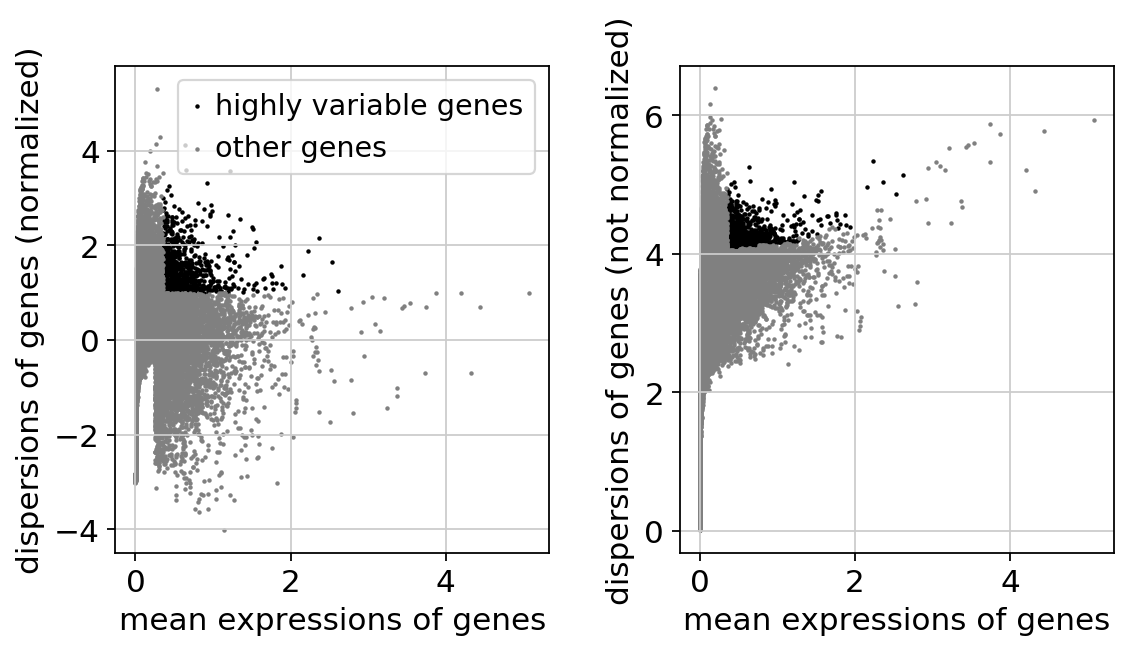

In [28]:

filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.35, max_mean=7, min_disp=1) ####L20C1 parameters 
  
sc.pl.filter_genes_dispersion(filter_result)


In [29]:
sum(filter_result.gene_subset)

789

In [30]:
#percent of genes that are highly variable
sum(filter_result.gene_subset)/len(filter_result.gene_subset)*100

1.570430524870126

In [31]:
adata = adata[:, filter_result.gene_subset]

In [32]:
sc.pp.log1p(adata)

In [33]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.14)


In [34]:
sc.pp.scale(adata, max_value=10)

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00.63)


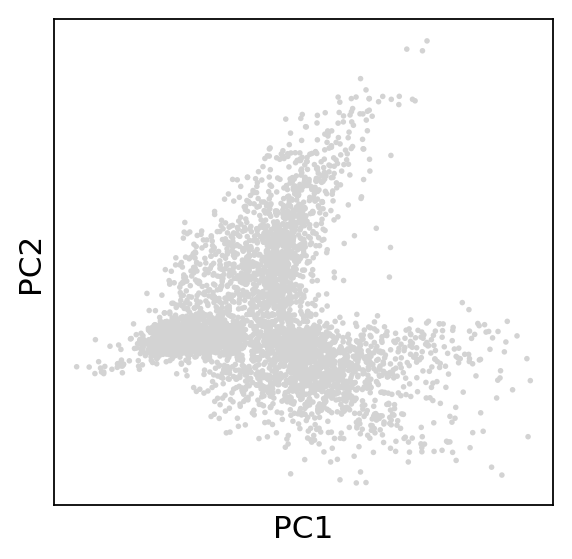

In [36]:
sc.pl.pca(adata)

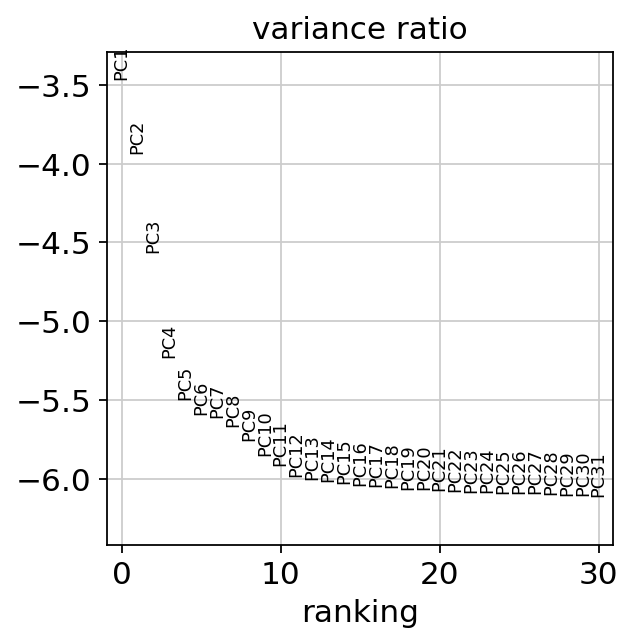

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)

In [38]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10


/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../venv3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../venv3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDep

    finished (0:00:02.75) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [39]:
sc.tl.leiden(adata, resolution=0.6)

running Leiden clustering
    finished (0:00:00.66) --> found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


In [40]:
sc.tl.louvain(adata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.40) --> found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [41]:
sc.tl.umap(adata,
            min_dist=.1,
            spread=2,
            alpha=2,
            )

computing UMAP
    using 'X_pca' with n_pcs = 10
    finished (0:00:07.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)


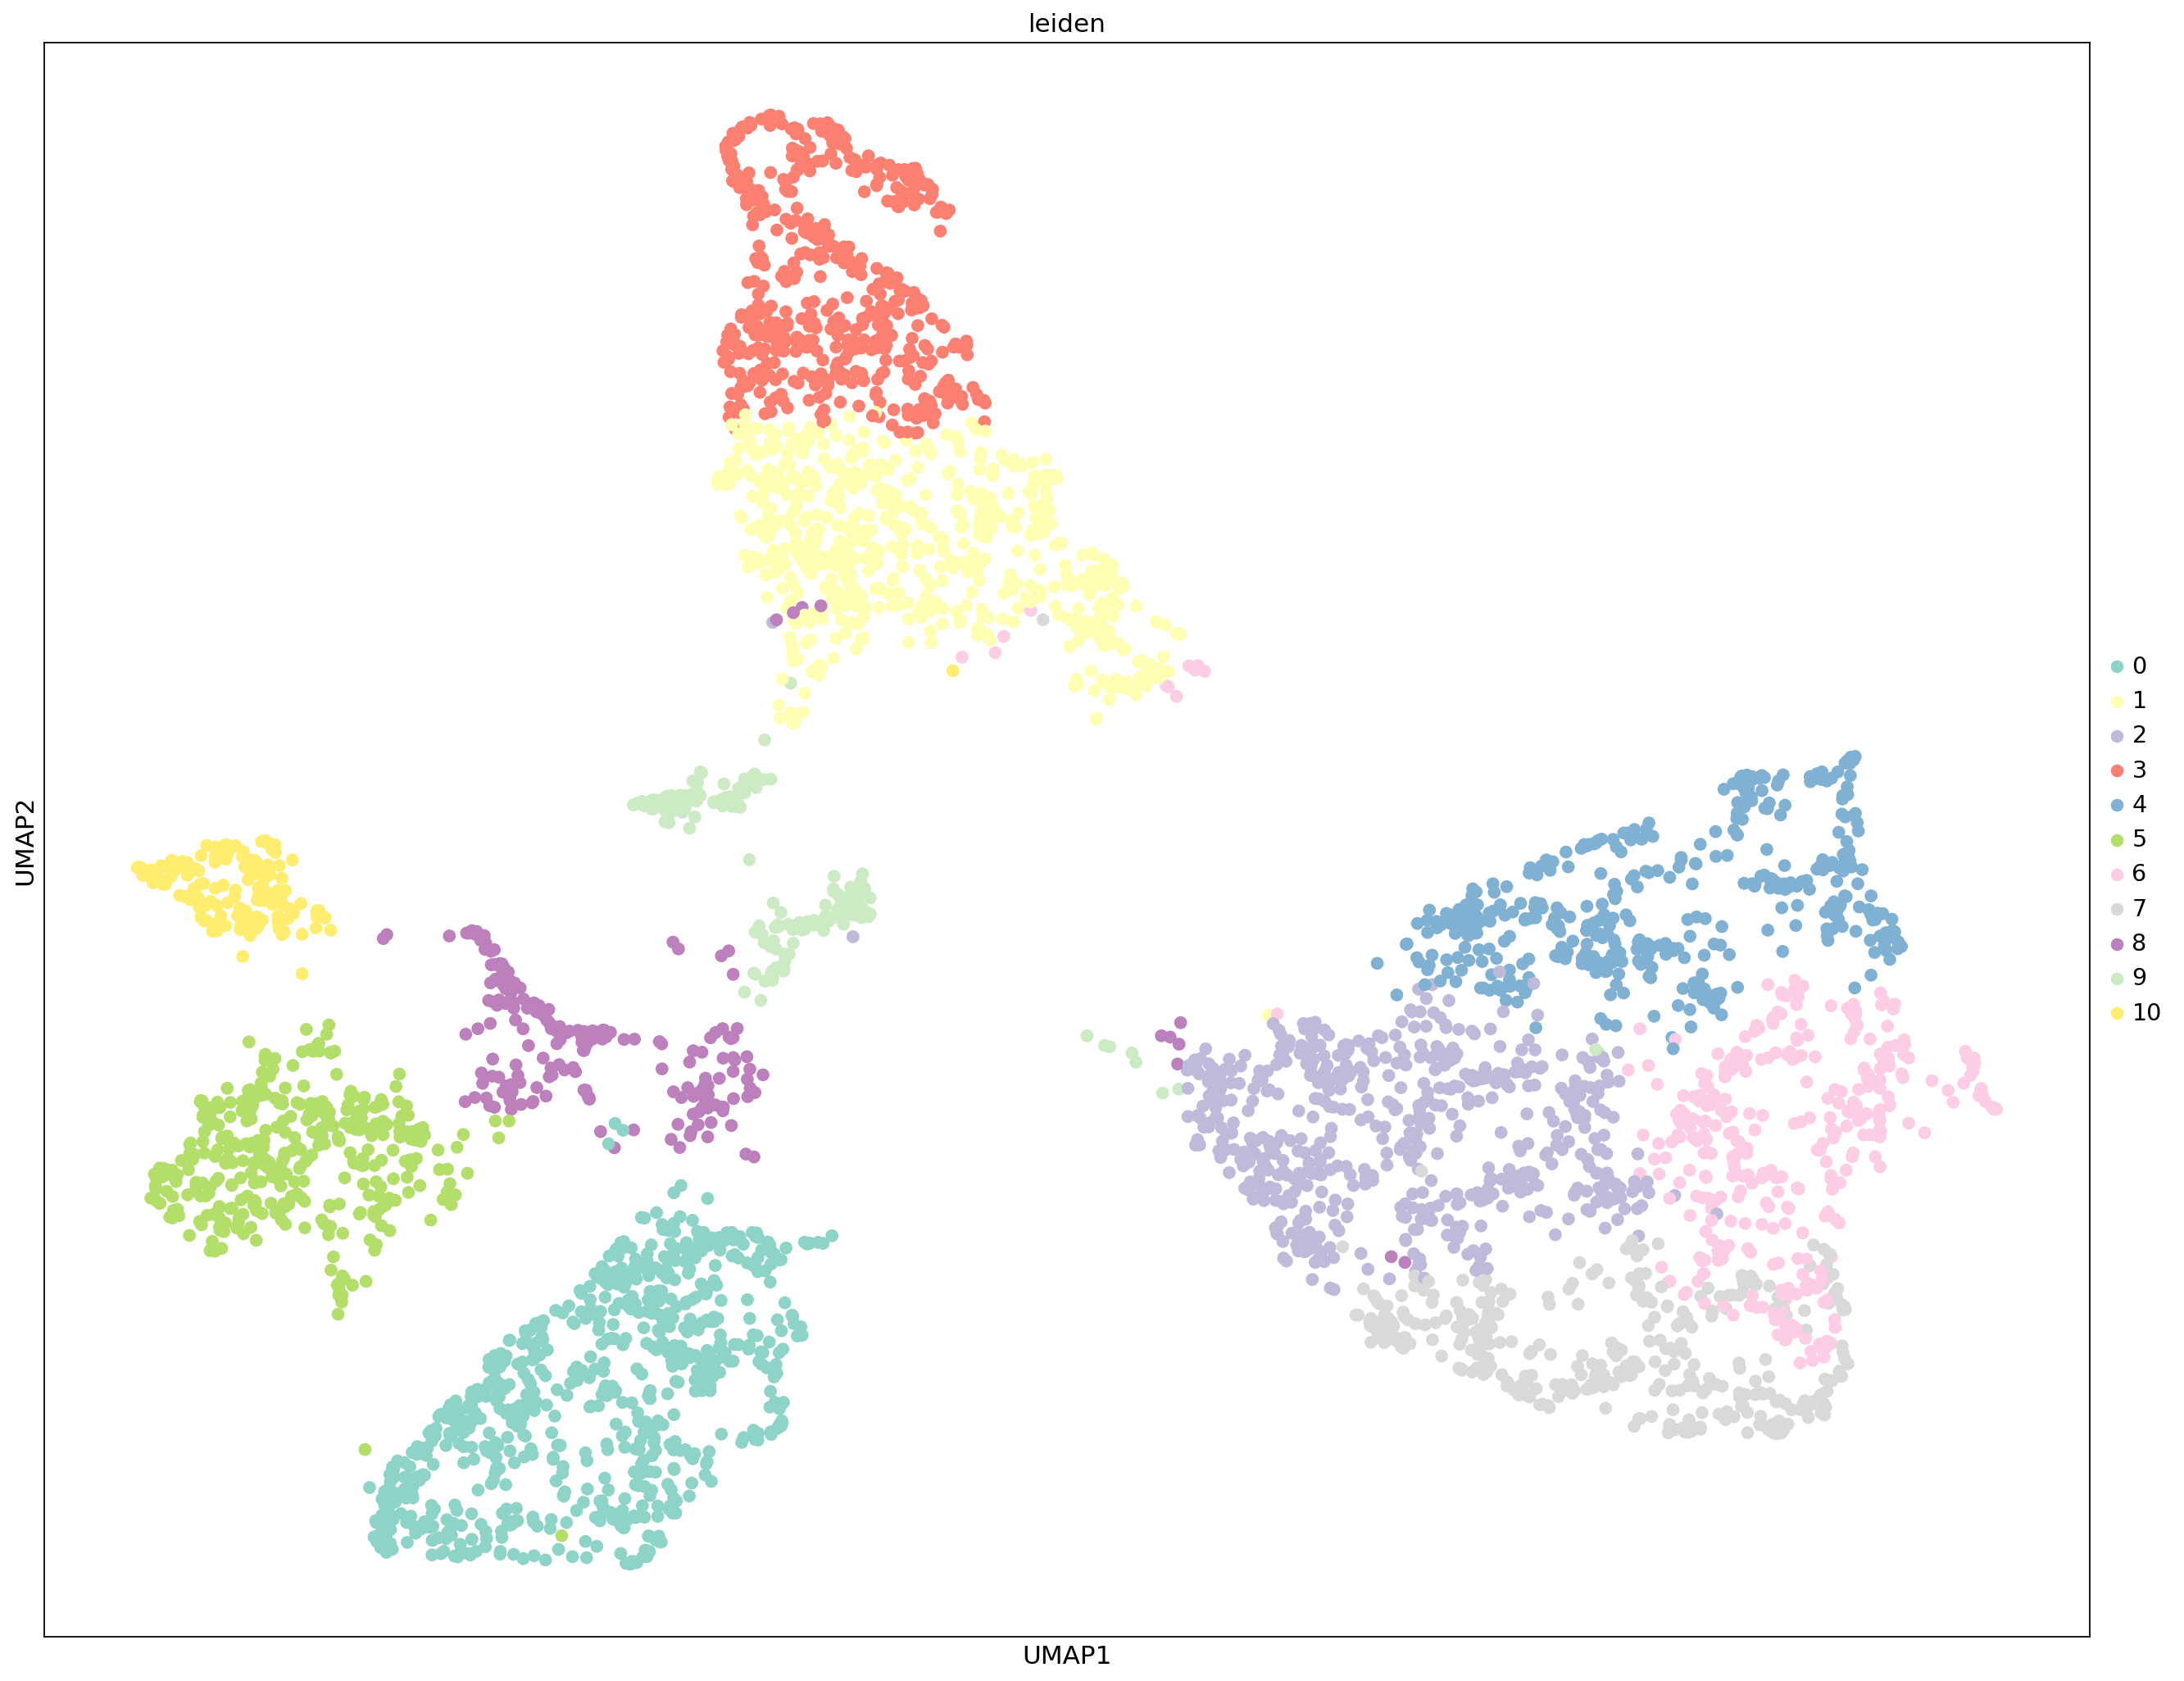

In [161]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['leiden'],
           ncols=4,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
      #     legend_loc='on data',
           size=200)

In [43]:
### define new annotation for celltype based on leiden clusters ####

cell_type_df=pd.DataFrame(adata.obs['leiden'])


def label (row):
   if row['leiden'] == '0':
      return 'mc38'
   if row['leiden'] =='1':
      return 'Hepatocyte'
   if row['leiden'] == '2':
      return 'Hek293t'
   if row['leiden'] == '3':
      return 'Hepatocyte'
   if row['leiden']  == '4':
      return 'Hek293t'
   if row['leiden'] == '5':
      return 'Macrophage'
   if row['leiden'] == '6':
      return 'Hek293t'
   if row['leiden'] == '7':
      return 'Hek293t'
   if row['leiden'] == '8':
      return 'Lymphocyte'
   if row['leiden'] == '9':
      return 'LSEC'
   if row['leiden'] == '10':    
      return 'Kupffer'
    
    
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata.obs['CellType']=cell_type_df_



... storing 'CellType' as categorical


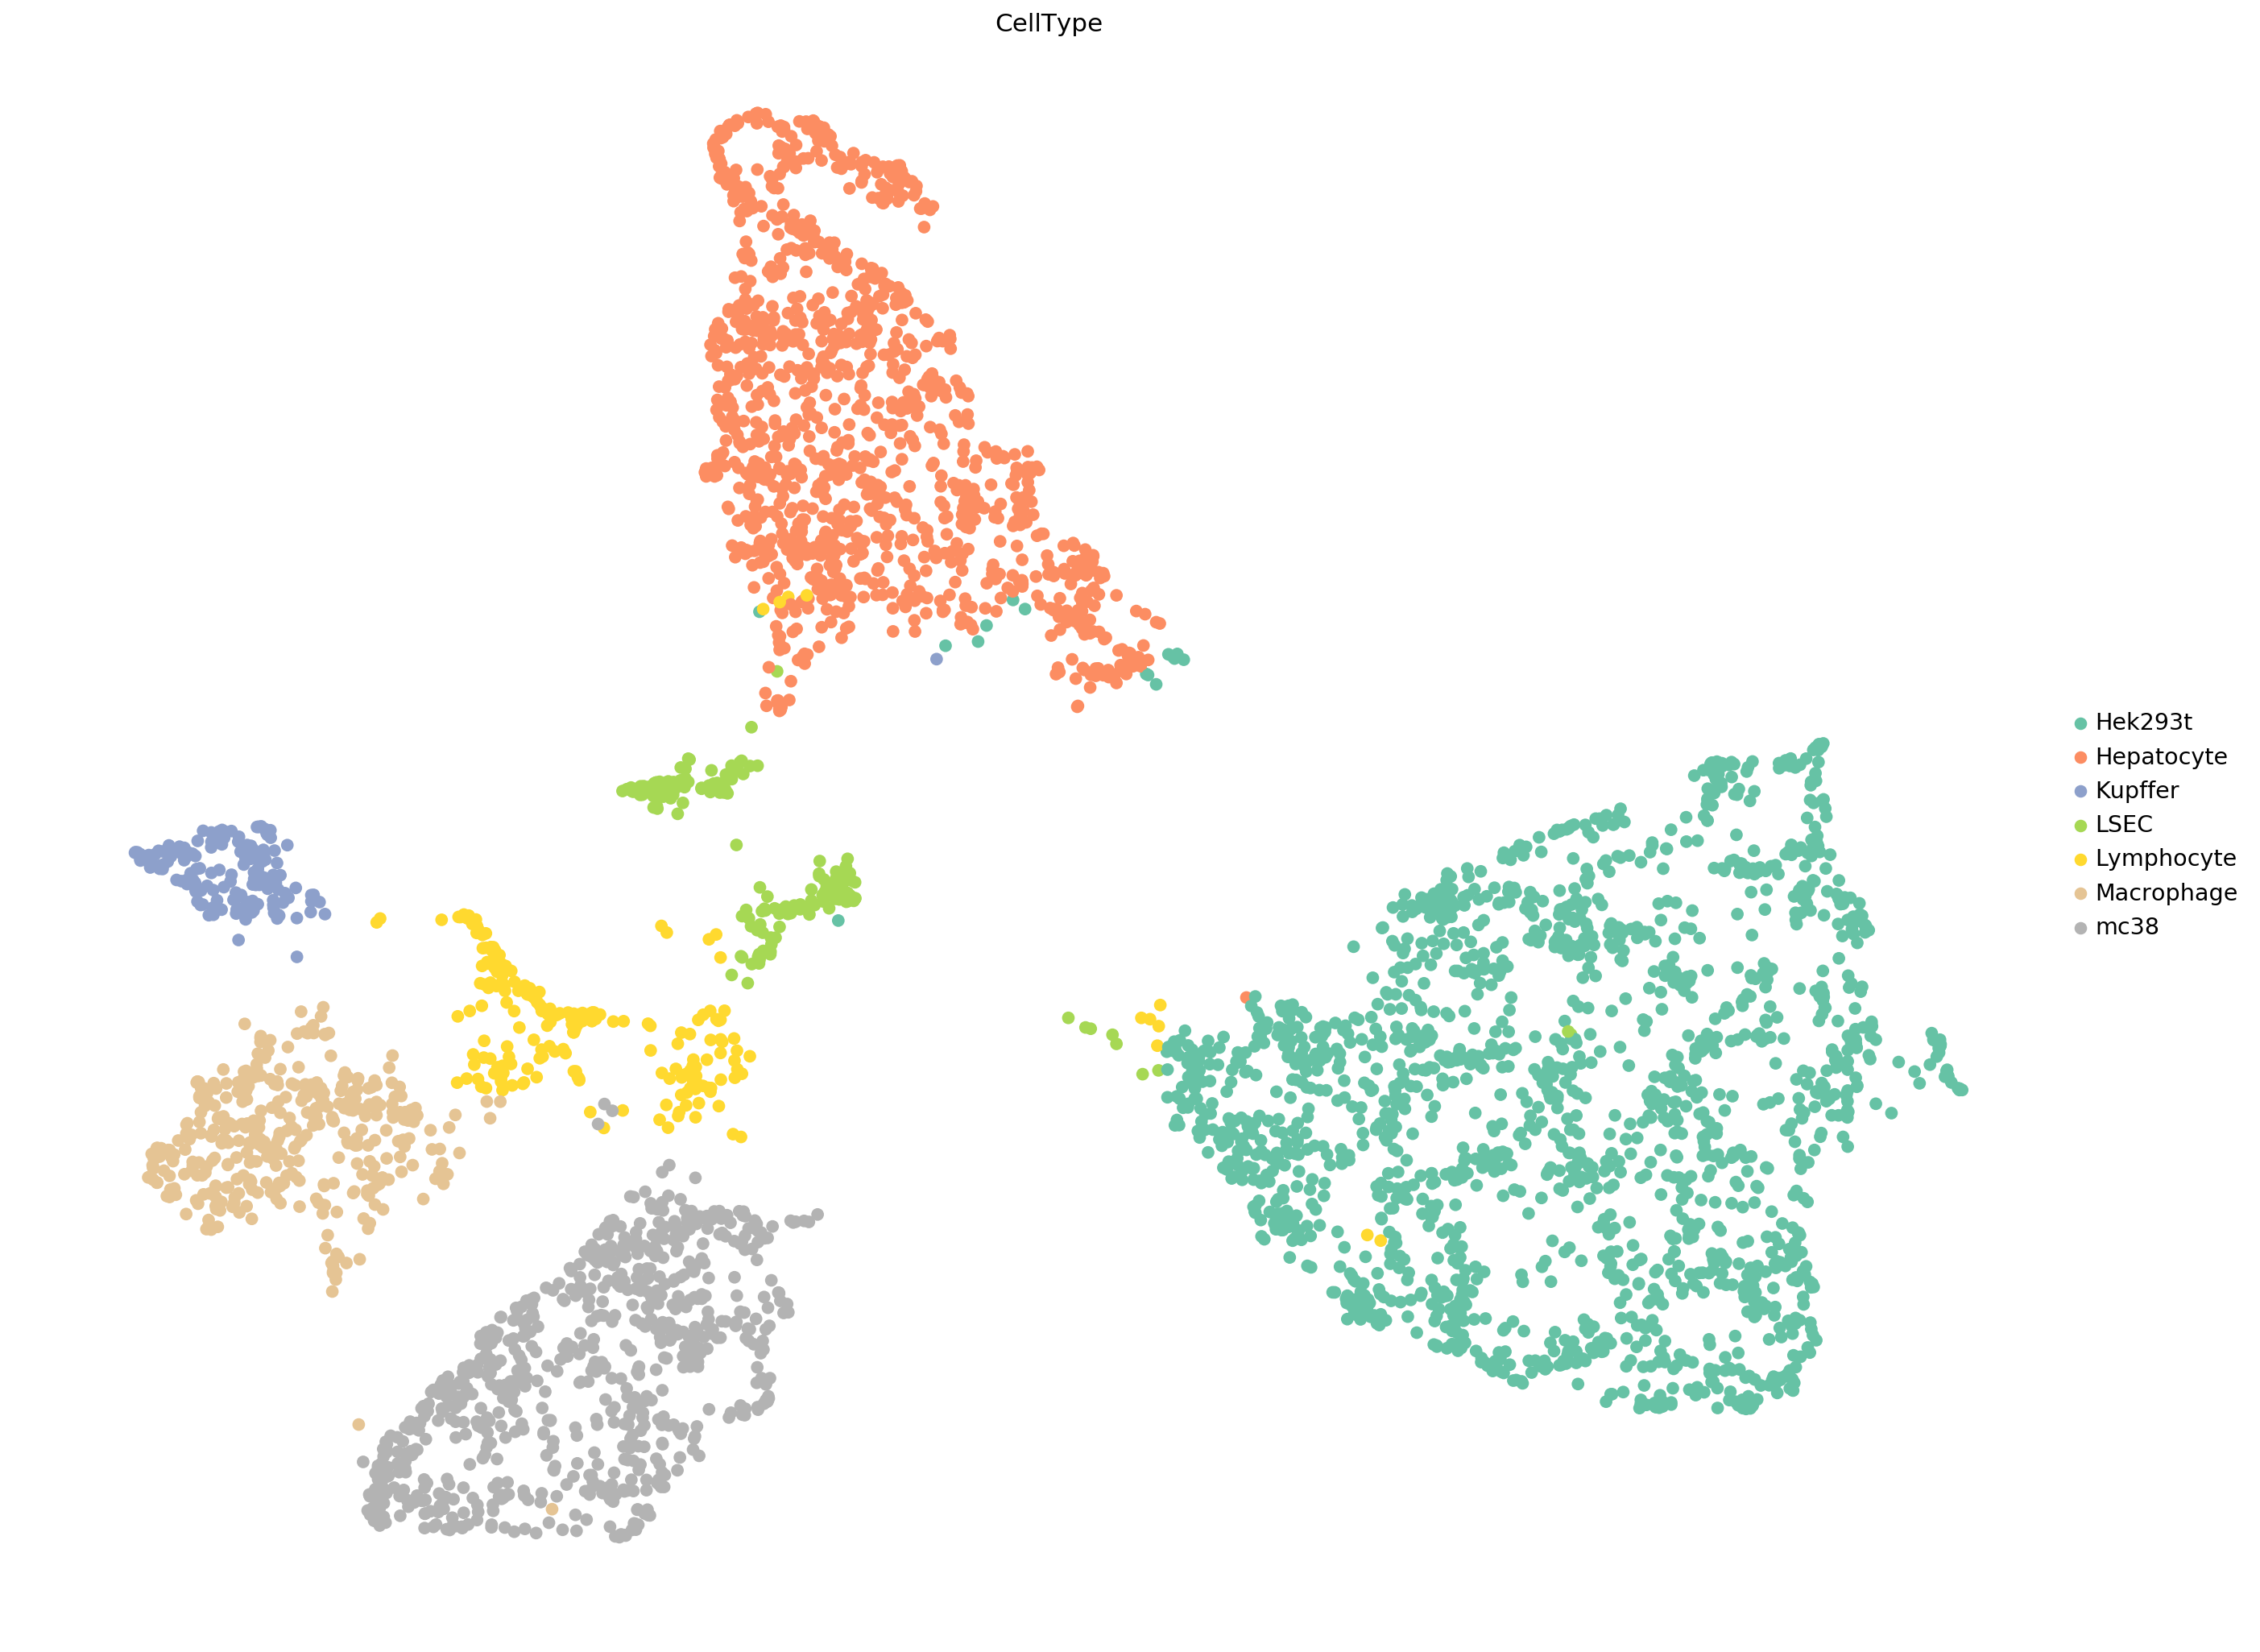

In [44]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['CellType'],
           ncols=1,
           palette="Set2",
           color_map=mpl.cm.CMRmap,
           frameon=False,
        #   legend_loc='on data',
        # save='test.svg',
           size=200,
          )




In [45]:
adata.uns['CellType_colors']

['#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

In [46]:
adata.uns['CellType_colors']=['#e41a1c',
                              '#377eb8',
                              '#984ea3',
                              '#ff7f00',
                              '#ffff33',
                              '#f781bf',
                              '#4daf4a']

In [47]:
from pylab import *

cmap = cm.get_cmap('Set1')    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

#e41a1c
#377eb8
#4daf4a
#984ea3
#ff7f00
#ffff33
#a65628
#f781bf
#999999


In [52]:
liver

x   y   area
0     4  10  liver
1     4  11  liver
2     4  12  liver
3     5   9  liver
4     5  10  liver
5     5  11  liver
6     5  12  liver
7     5  13  liver
8     5  14  liver
9     6   8  liver
10    6   9  liver
11    6  10  liver
12    6  11  liver
13    6  12  liver
14    6  13  liver
15    6  14  liver
16    6  15  liver
17    7   8  liver
18    7   9  liver
19    7  10  liver
20    7  11  liver
21    7  12  liver
22    7  13  liver
23    7  14  liver
24    7  15  liver
25    7  16  liver
26    7  17  liver
27    8   8  liver
28    8   9  liver
29    8  10  liver
..   ..  ..    ...
133  20  17  liver
134  21  10  liver
135  21  11  liver
136  21  15  liver
137  21  16  liver
138  21  17  liver
139  22  10  liver
140  22  11  liver
141  22  16  liver
142  23  10  liver
143  23  11  liver
144  23  16  liver
145  23  17  liver
146  24   9  liver
147  24  10  liver
148  24  16  liver
149  24  17  liver
150  25  10  liver
151  25  11  liver
152  25  17  liver
153  25  18  liver
154  26  10  liver
155  26  17  liver
156  27  11  liver
157  27  18  liver
158  28  10  liver
159  28  17  liver
160  29  11  liver
161  29  17  liver
162  30  17  liver

[163 rows x 3 columns]

In [54]:
tumor=pd.read_csv("../../../XYZeq/L20C1_tumor_wells.csv")
liver=pd.read_csv("../../../XYZeq/L20C1_liver_wells.csv")

liver.columns=['X','Y']
tumor.columns=['X','Y']

liver['area']='liver'
tumor['area']='tumor'

liver['coordinate']=liver['X'].map(str)+','+liver['Y'].map(str)
liver=liver.drop(['X','Y'],axis=1)

tumor['coordinate']=tumor['X'].map(str)+','+tumor['Y'].map(str)
tumor=tumor.drop(['X','Y'],axis=1)

In [55]:
tissue_type=pd.concat([liver,tumor])
tissue_type=tissue_type.reset_index(drop=True)

In [56]:
plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

spatial_map['coordinate']=spatial_map['X'].map(str)+','+spatial_map['Y'].map(str)
tissue_type_map=spatial_map.drop(['X','Y'],axis=1)

In [57]:
tissue_type=tissue_type_map.merge(tissue_type,on=['coordinate'], how='left')

tissue_type=tissue_type.fillna('none')

tissue_type=tissue_type.drop(['coordinate'],axis=1)

In [58]:

df=pd.DataFrame(adata.obs.CellType)
df['barcode']=df.index.str[-16:]

In [59]:
adata.obs['barcode']=df['barcode']

In [60]:
ref=pd.DataFrame(adata.obs['barcode'])
tissue_type=ref.merge(tissue_type, on='barcode',how='left')#.reindex(adata.obs_names)

tissue_type.index=adata.obs_names
tissue_type=tissue_type.drop('barcode',axis=1)

adata.obs['area_1']=tissue_type

In [61]:
adata

AnnData object with n_obs × n_vars = 4788 × 789 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain', 'CellType', 'barcode', 'area_1'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'louvain', 'leiden_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'barcode' as categorical
... storing 'area_1' as categorical


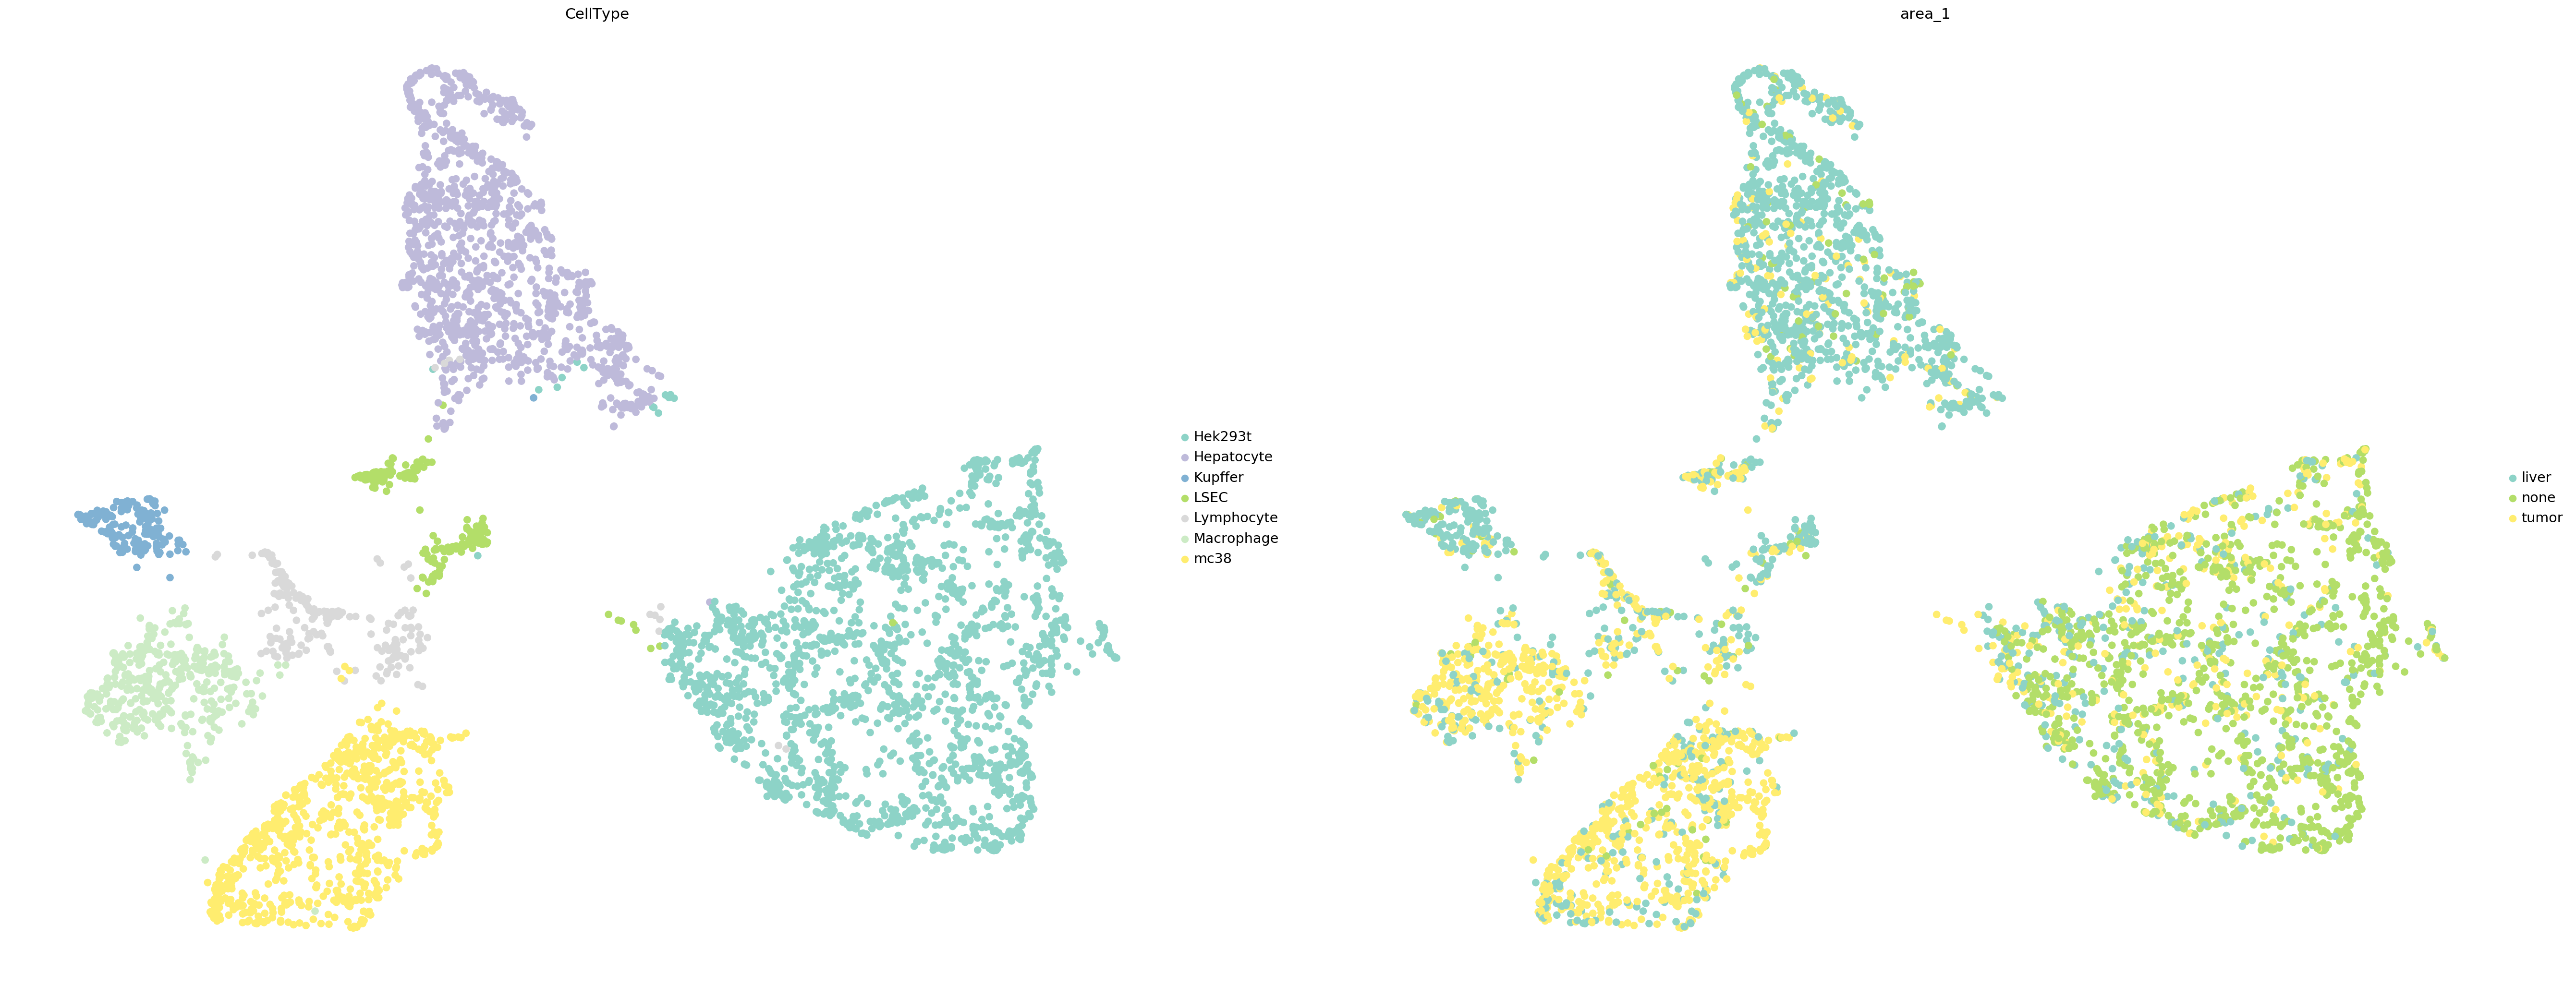

In [62]:
plt.rcParams['figure.figsize'] = [20, 16]

sc.pl.umap(adata, 
           color=['CellType','area_1'],
           ncols=2,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
           frameon=False,
        #   legend_loc='on data',
        # save='test.svg',
           size=200,
          )


In [156]:
adata_Lymphocyte=adata[adata.obs['CellType']=='Lymphocyte']
adata_Macrophage=adata[adata.obs['CellType']=='Macrophage']
adata_Hepatocyte=adata[adata.obs['CellType']=='Hepatocyte']


In [162]:
# sc.tl.rank_genes_groups(adata_Lymphocyte, 
#                         'area_1',
#                        )

# sc.pl.rank_genes_groups(adata_Lymphocyte, 
#                         n_genes=40, 
#                  #       groups=[str(3)],
#                         ncols=1,
#                         fontsize=20,
#                         sharey=False
#                        )

In [163]:
# sc.tl.rank_genes_groups(adata_Macrophage, 
#                         'area_1',
#                        )

# sc.pl.rank_genes_groups(adata_Macrophage, 
#                         n_genes=40, 
#                  #       groups=[str(3)],
#                         ncols=1,
#                         fontsize=20,
#                         sharey=False
#                        )

In [164]:
# sc.tl.rank_genes_groups(adata_Hepatocyte, 
#                         'area_1',
#                        )

# sc.pl.rank_genes_groups(adata_Hepatocyte, 
#                         n_genes=40, 
#                  #       groups=[str(3)],
#                         ncols=1,
#                         fontsize=20,
#                         sharey=False
#                        )

In [64]:
plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

In [65]:
cutoff=0

In [66]:
def hexagon(x, y, c='k'):
	from matplotlib.patches import Polygon

	points = [[x + (2/3), y],
			  [x + (1/3), y + 0.5],
   			  [x - (1/3), y + 0.5],
              [x - (2/3), y],
   			  [x - (1/3), y - 0.5],
   			  [x + (1/3), y - 0.5]]
    
	polygon = Polygon(points, edgecolor='w', fc=c)
	return polygon

In [275]:
df=pd.DataFrame(adata.obs.area_1)



In [276]:
df['barcode']=df.index.str[-16:]

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


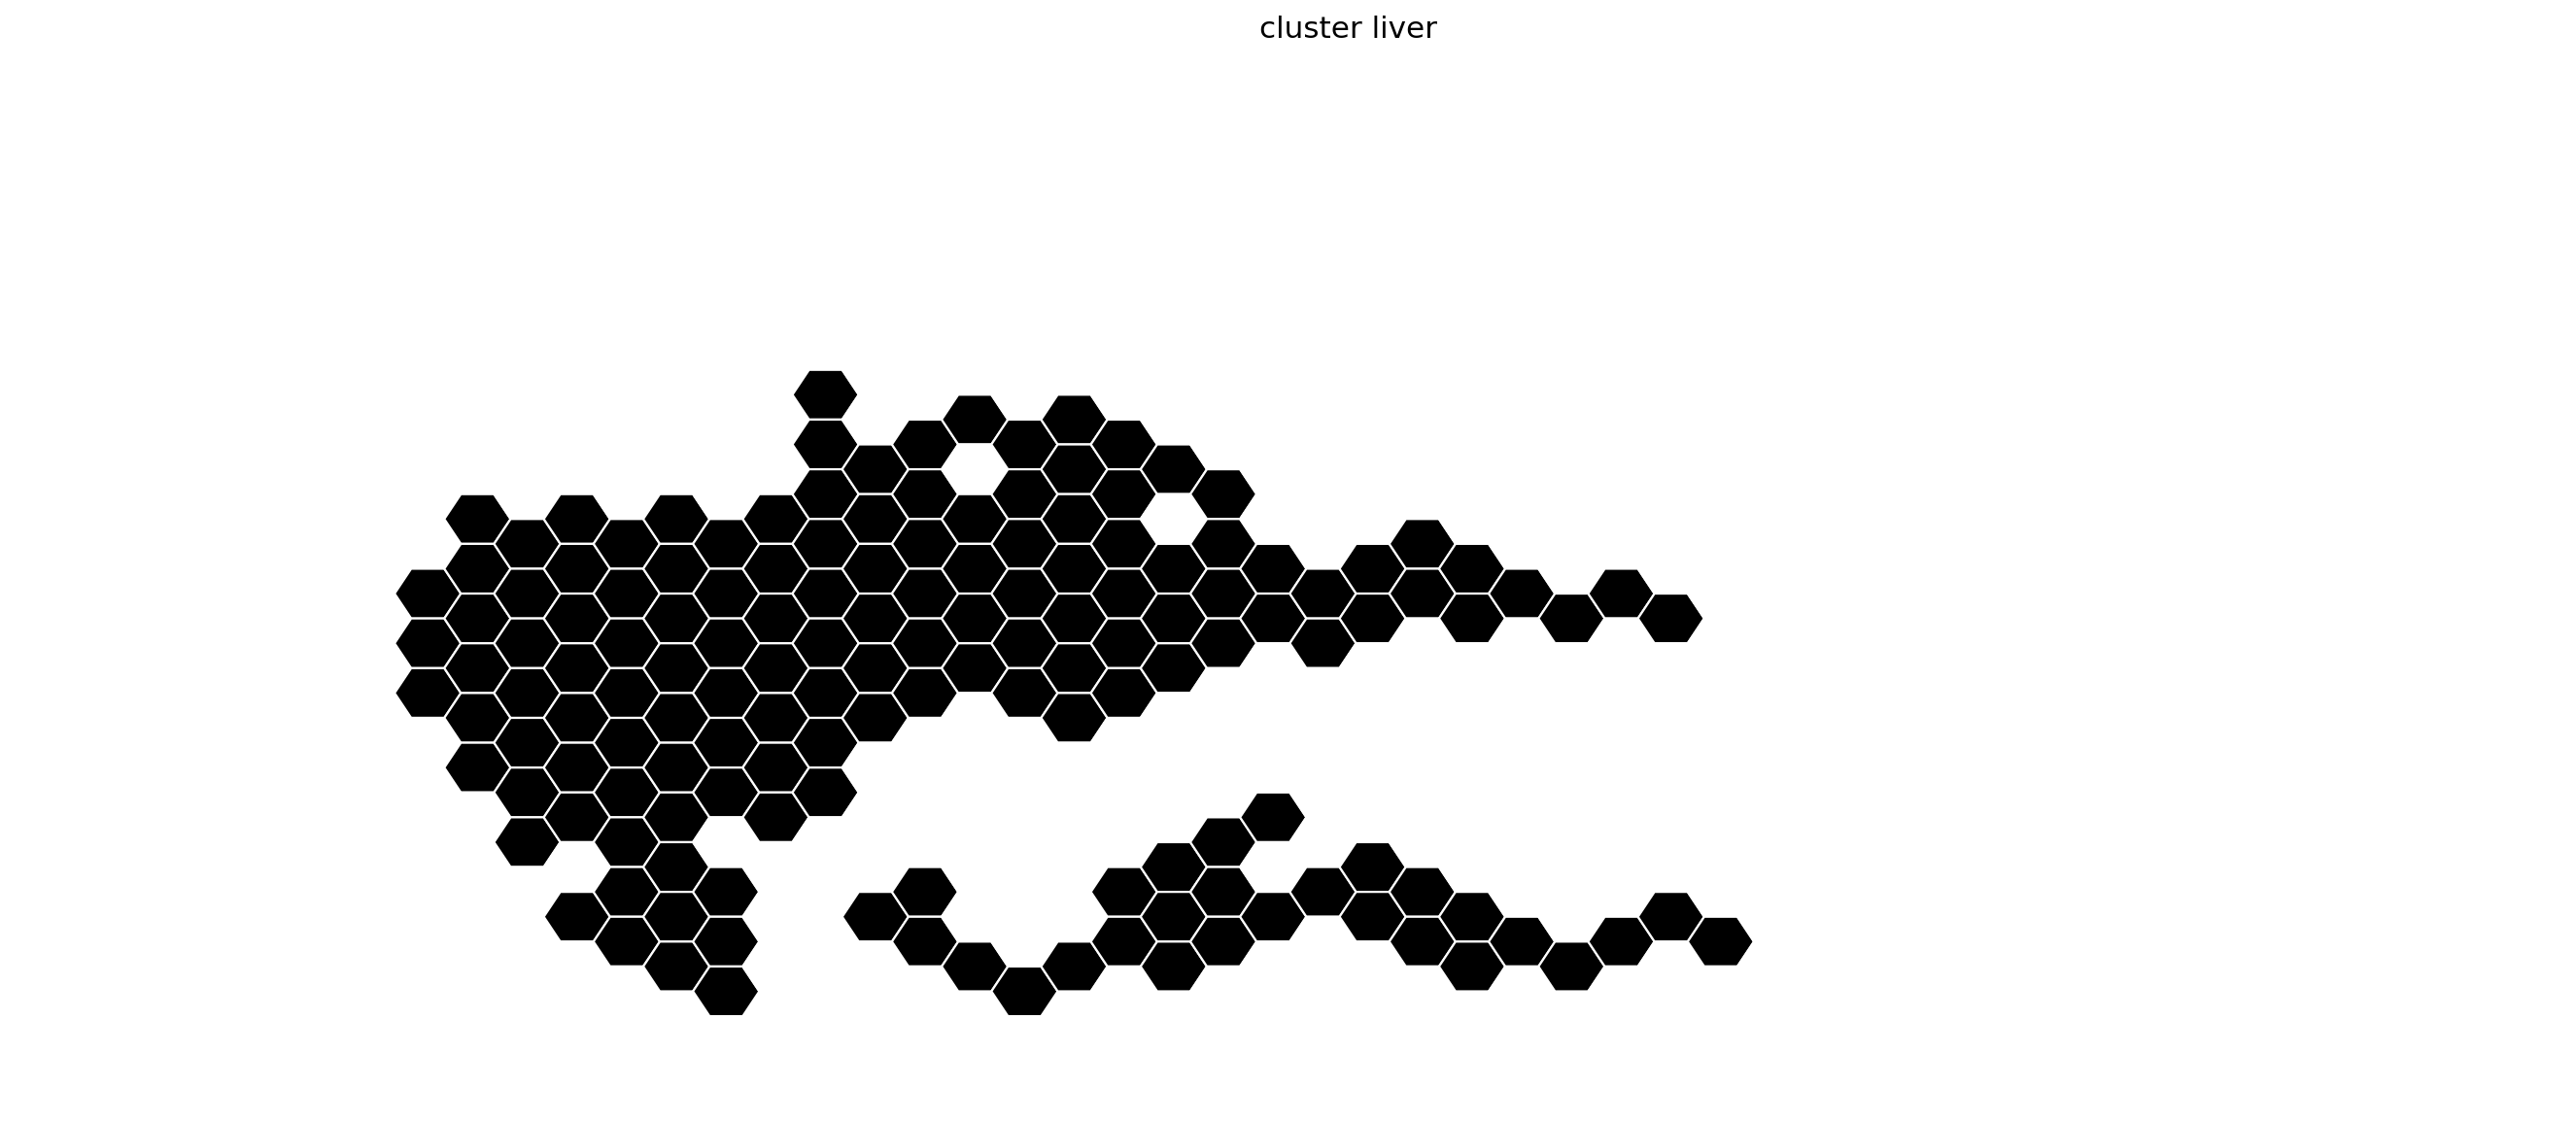

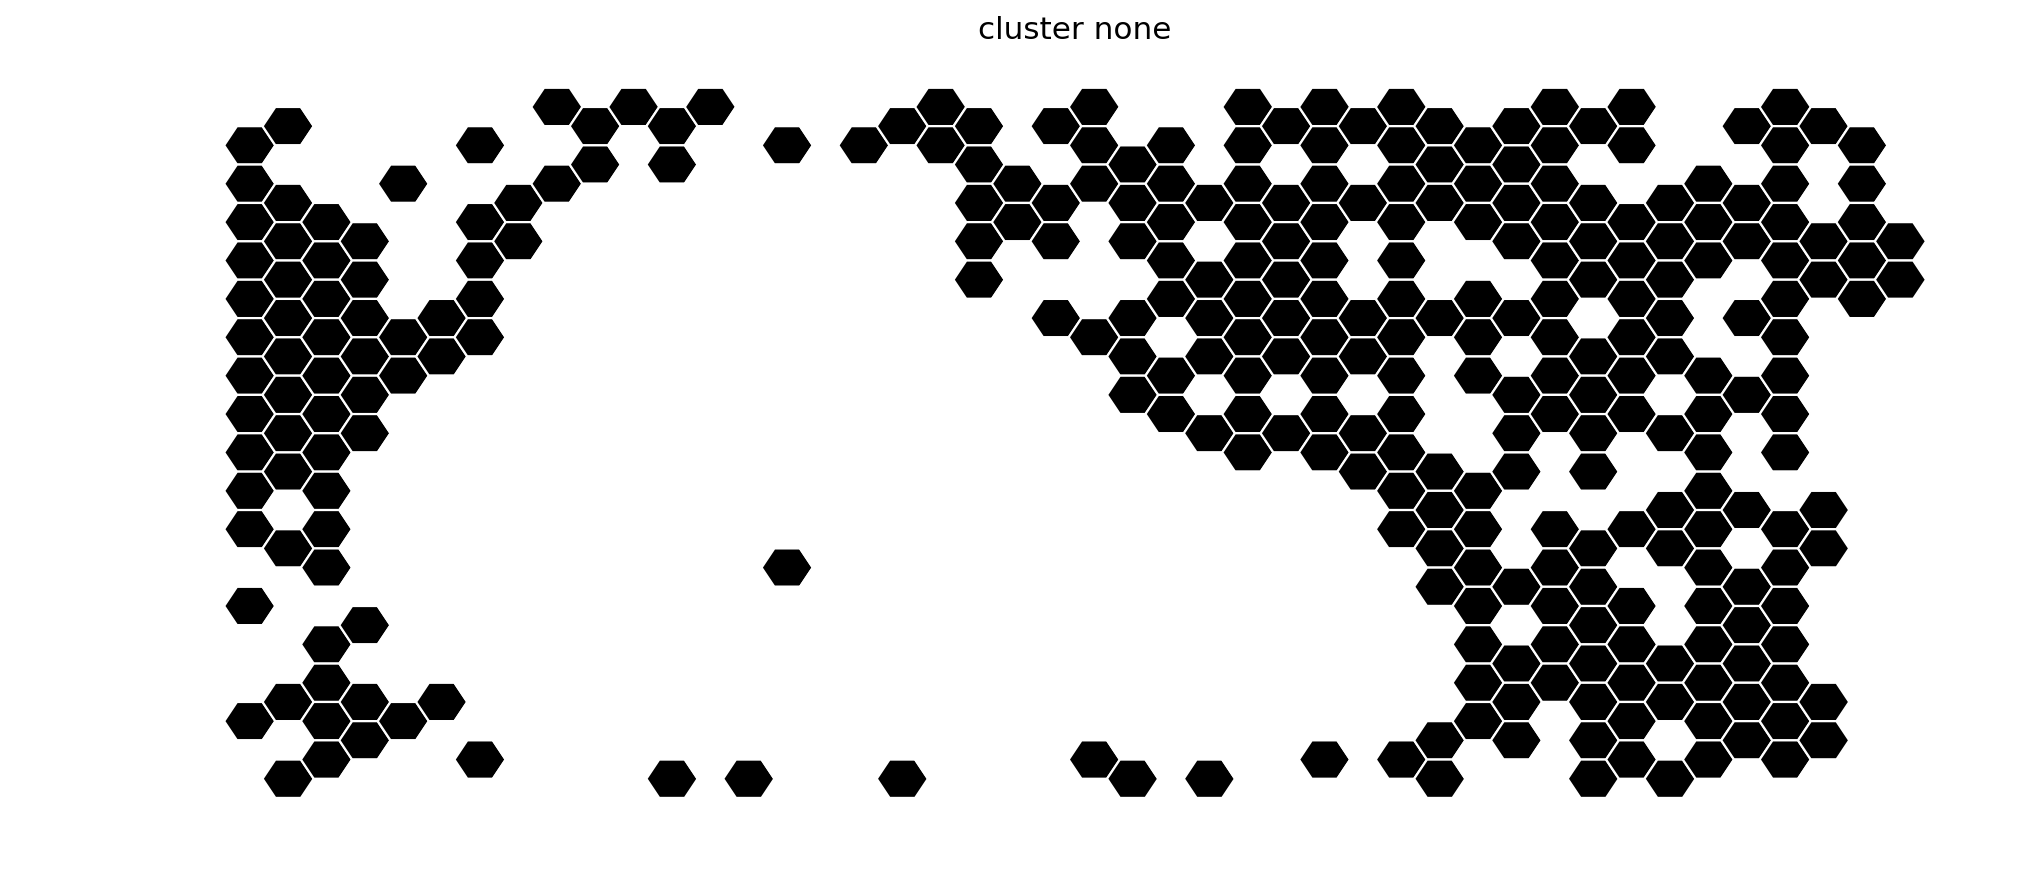

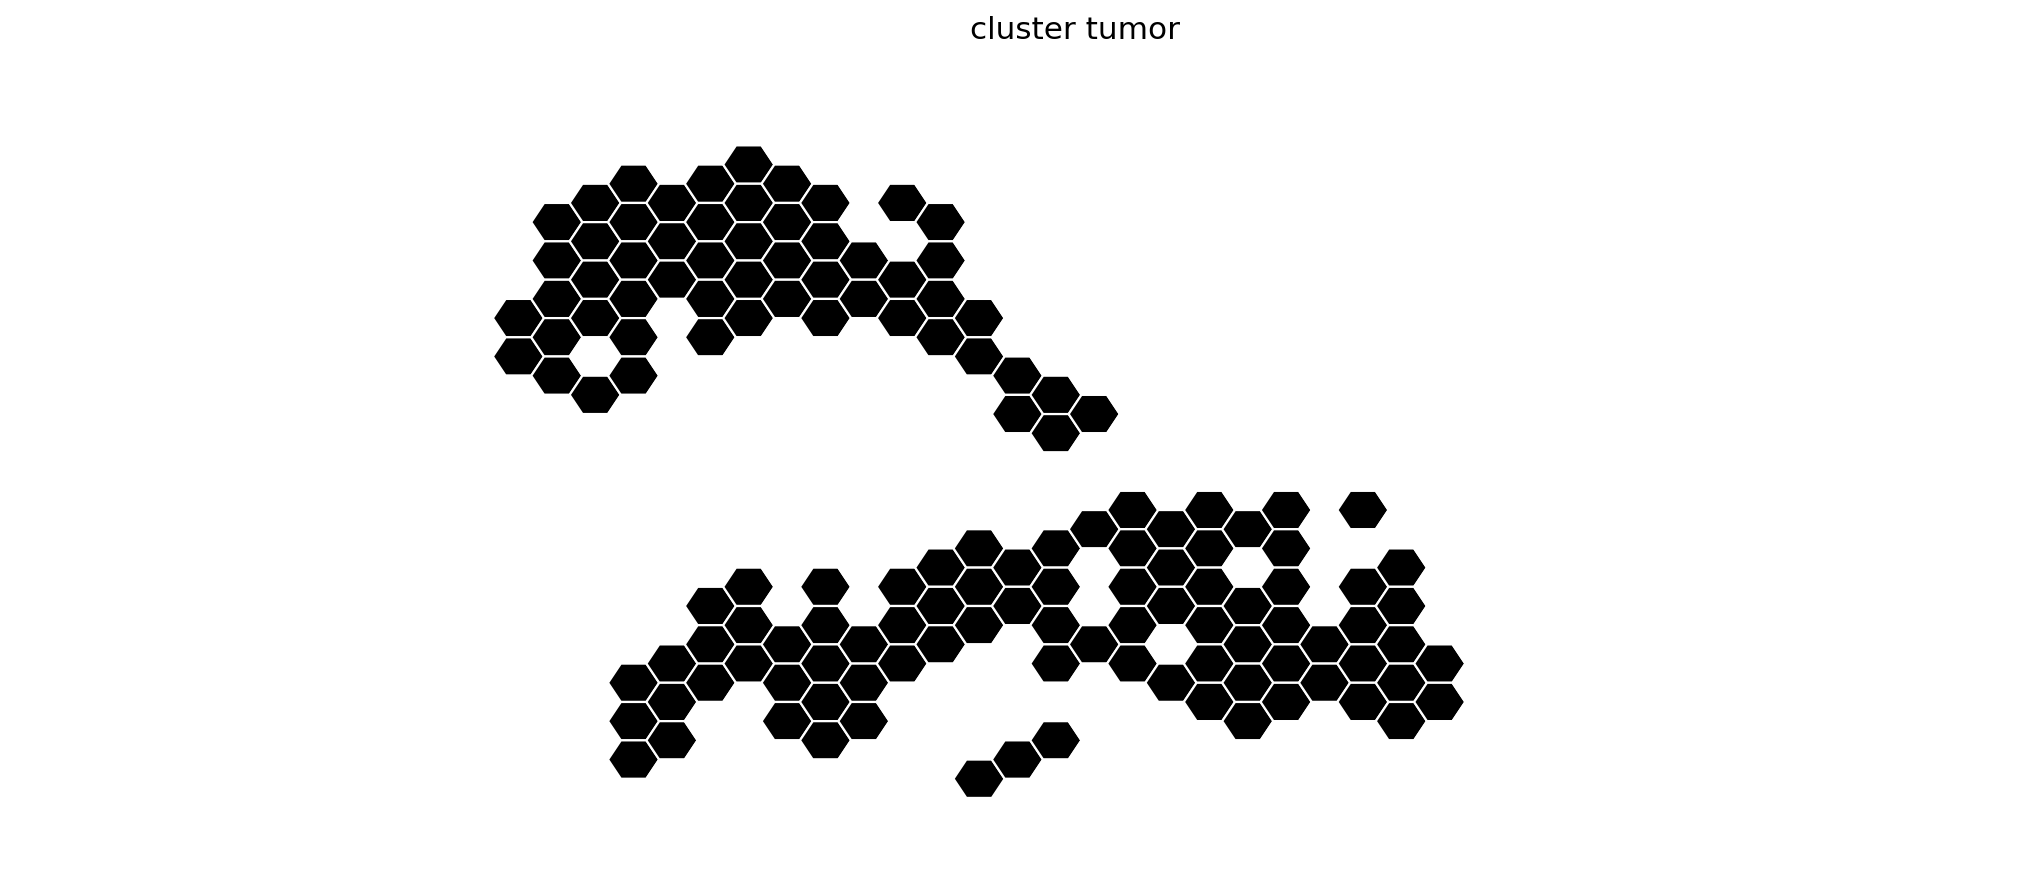

In [69]:

color_itorator=0



for t in adata.obs.area_1.cat.categories:
#for t in ['1']:
    df_=df[df['area_1'] == t]
    
    #sets cell counter
    df_['count']=1
    
    df__=df_.groupby('barcode', as_index=False)['count'].sum()

    map_array=spatial_map.merge(df__, on='barcode', how='left')
    
    map_array=map_array.fillna('0')
    map_array['count']=map_array['count'].astype(int)
    
    
    
    # max value for coloring
    max_val=max(map_array['count'])
    norm = mpl.colors.Normalize(vmin=0,vmax=max_val)
    
    custom_color=adata.uns['CellType_colors'][color_itorator]
    custom_map = mpl.colors.LinearSegmentedColormap.from_list("", ["#ffffff",custom_color])
    
    color_itorator = color_itorator+1
    
    count_hex=[]
    for i in map_array['count']:
        if i > cutoff:

        #    count_hex.append(mpl.colors.rgb2hex(custom_map(norm(i))[:3]))
            count_hex.append('#000000')
            
        else:
            count_hex.append('#ffffff')

    map_array['color']=count_hex
    
    for index, row in map_array.iterrows():
        if row['X'] % 2 != 0:
            row['Y']=row['Y']-0.5
    
        polygon = hexagon(row['X'],row['Y'],row['color'])
        plt.gca().add_patch(polygon)
    
  
    plt.ylim(18,0) #flip y axis
    plt.axis('scaled')
    plt.rcParams['figure.figsize'] = [15, 7.5] 
    
    plt.ylabel('cell number')
    plt.title('cluster %s' %t) 
    plt.axis('off')

    
    
    
    
#fix this here...
 #   mesh = plt.pcolormesh(pd.DataFrame(map_array['count']), cmap=custom_map)
 #   plt.colorbar(mesh)
    
 #   plt.savefig('/Users/derekbogdanoff/Desktop/test.svg', bbox_inches='tight')
    plt.show()

In [109]:
# plt.rcParams['figure.figsize'] = [20, 16]

# from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# import scipy.misc
# from scipy import ndimage
# import matplotlib.pyplot as plt








# fig, ax = plt.subplots()

# # ax.set_xlim(0, 1)
# # ax.set_ylim(0, 1)

arr_image = mpimg.imread('/Users/derekbogdanoff/Desktop/h_and_e_liver.jpg')


imagebox = OffsetImage(arr_image, zoom=2.2)
type(imagebox)
# ab = AnnotationBbox(imagebox, (0.6, 0.6))

# ax.add_artist(ab)














# plt.grid()

# plt.draw()
# #plt.savefig('add_picture_matplotlib_figure.png',bbox_inches='tight')
# plt.show()

matplotlib.offsetbox.OffsetImage

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


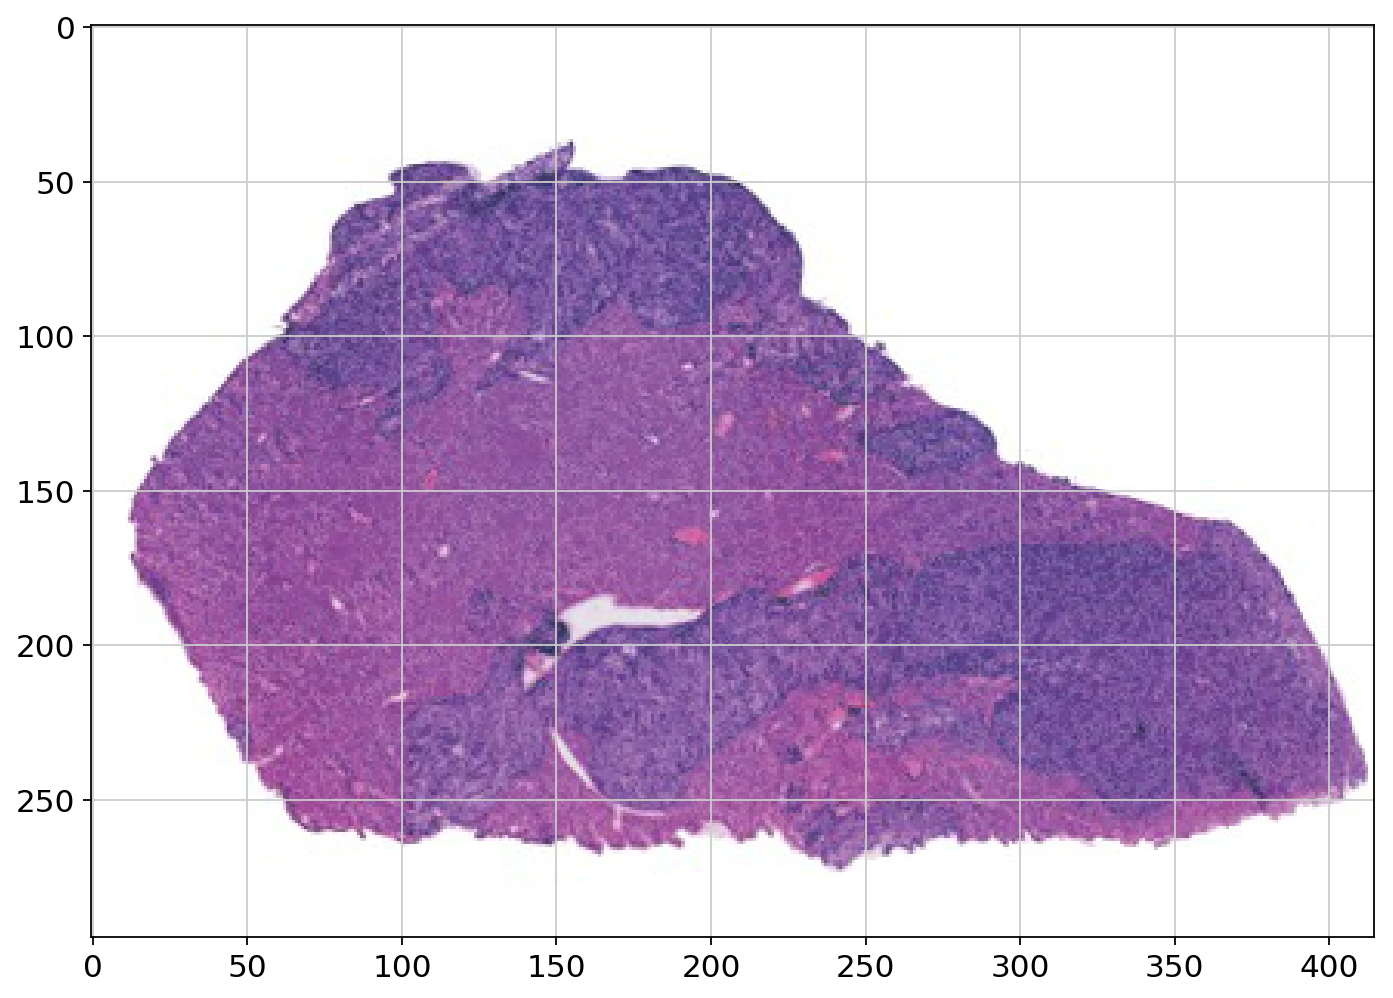

In [298]:
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt



####layer 1 

img =  mpimg.imread('/Users/derekbogdanoff/Desktop/h_and_e_liver.jpg') #scipy.misc.face()  # lena is not included in scipy 0.19.1
tr = scipy.ndimage.rotate(img,5,cval=255)
imgplot=plt.imshow(tr,zorder=1)


####layer 2

#plt.scatter(test['x'],test['y'],s=400,c='yellow',zorder=2)
#plt.ylim(18,0) #flip y axis

In [378]:
#add variable alpha

def hexagon(x, y, c='k'):
	from matplotlib.patches import Polygon

	points = [[x + (2/3), y],
			  [x + (1/3), y + 0.5],
   			  [x - (1/3), y + 0.5],
              [x - (2/3), y],
   			  [x - (1/3), y - 0.5],
   			  [x + (1/3), y - 0.5]]
    
	polygon = Polygon(points, edgecolor='w', fc=c, alpha=0.5)
	return polygon

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/matplotlib/pyplot.py:934: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  Add a subplot to the current figure.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


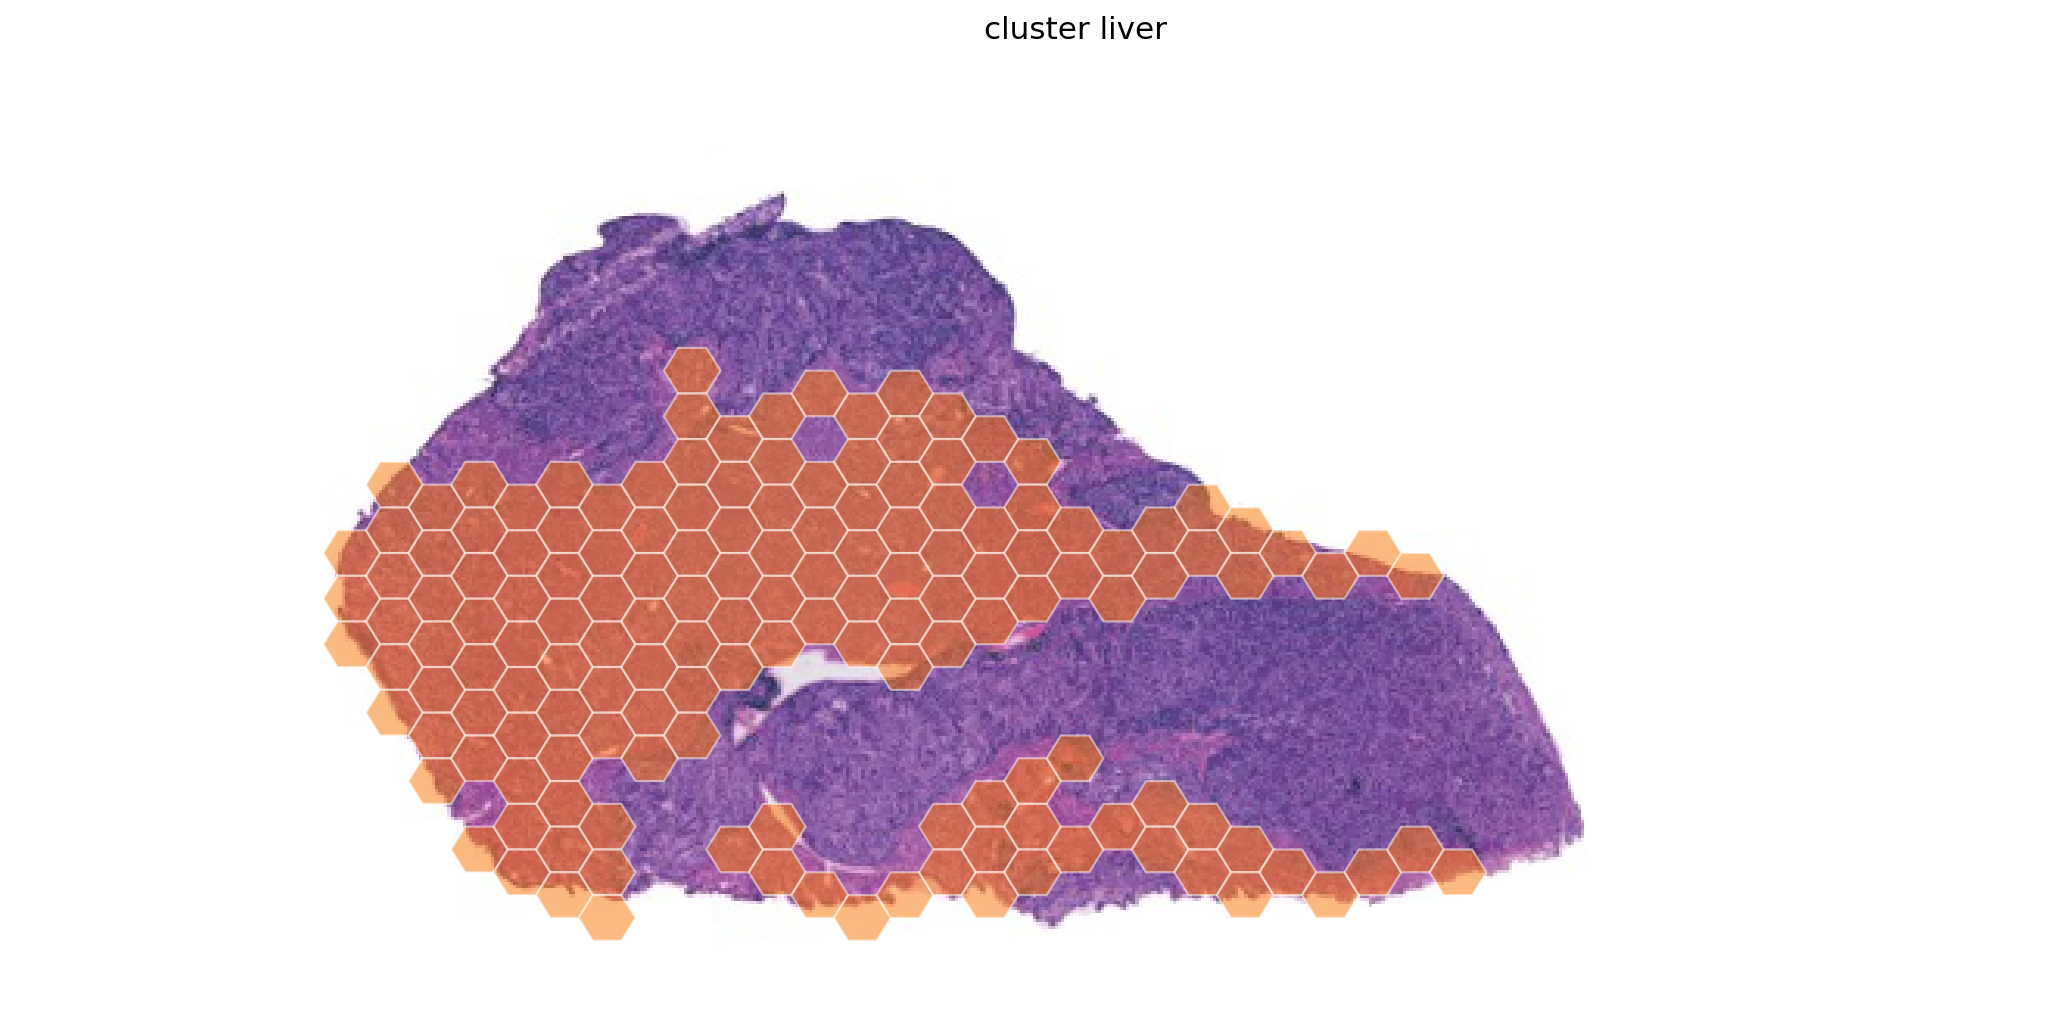

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/matplotlib/pyplot.py:934: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  Add a subplot to the current figure.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


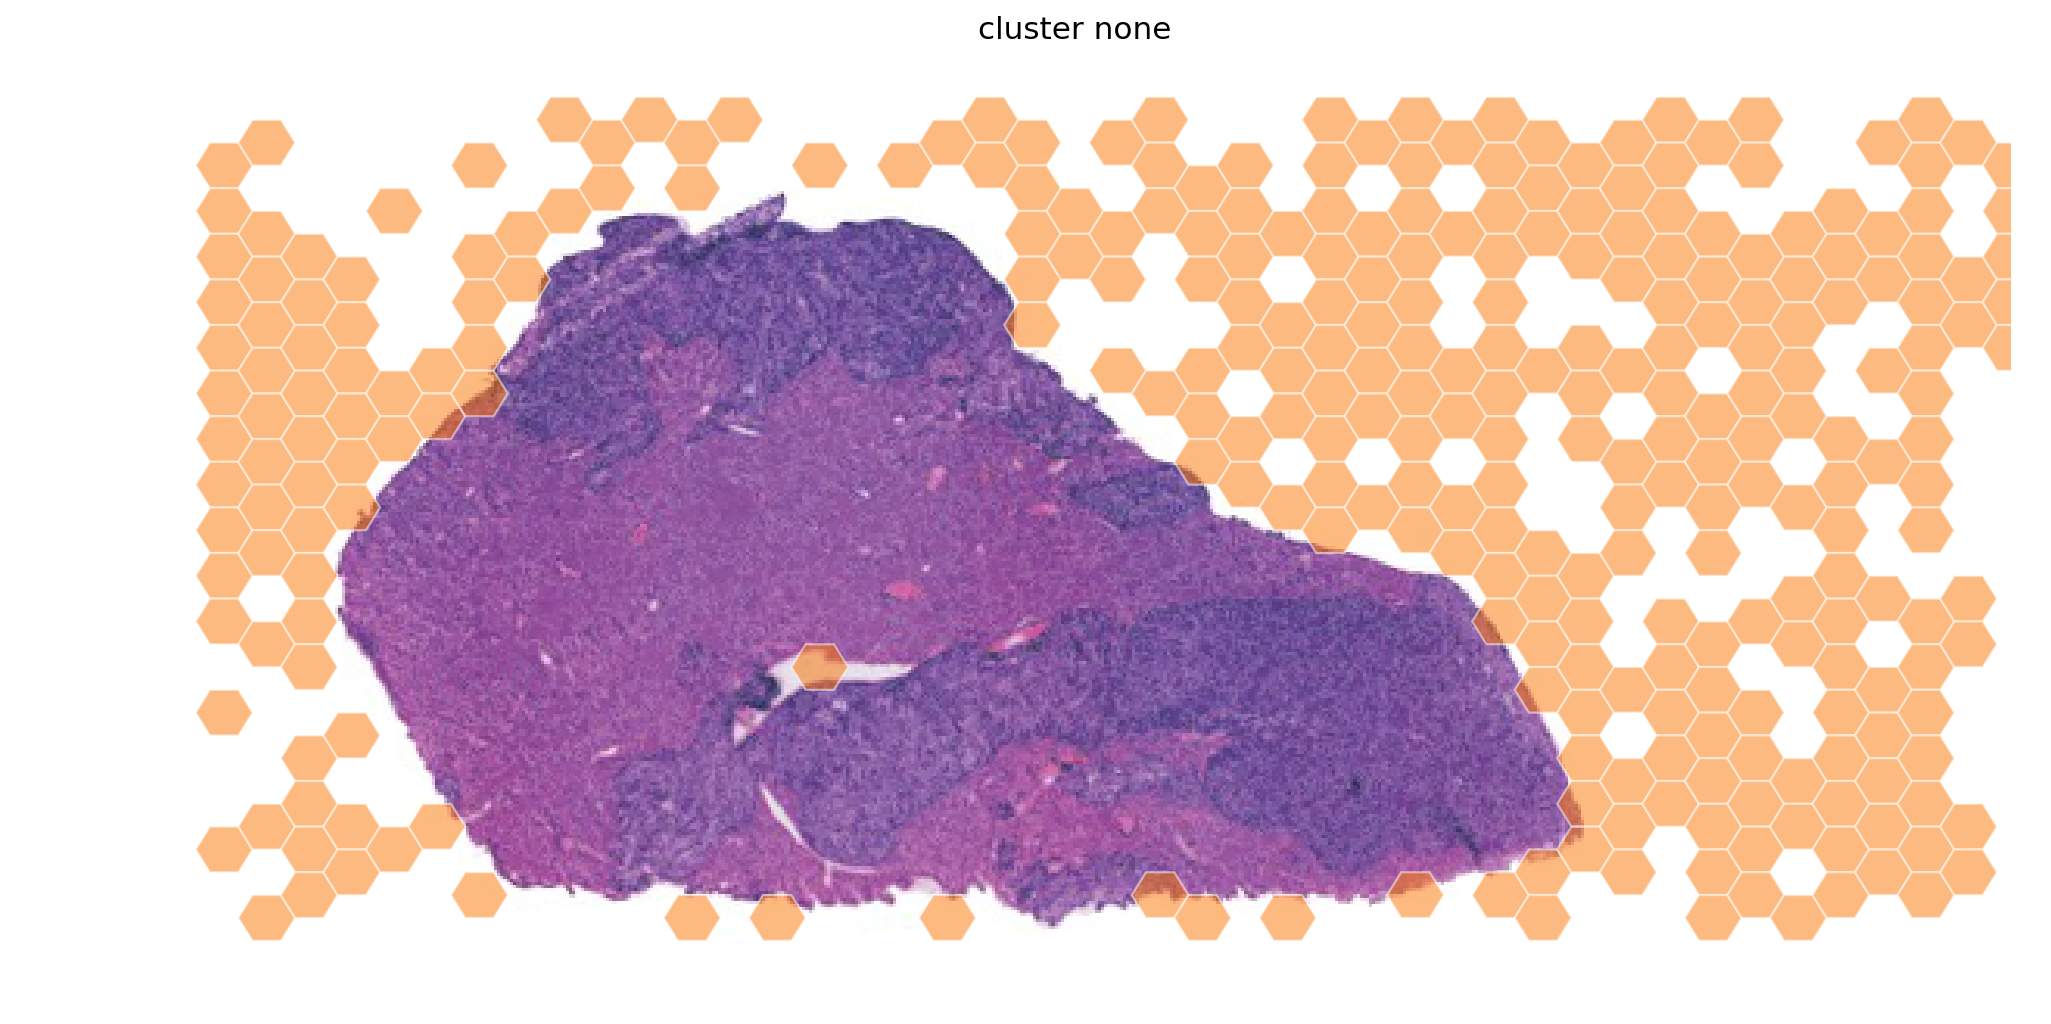

/Users/derekbogdanoff/projects/venv3/lib/python3.7/site-packages/matplotlib/pyplot.py:934: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  Add a subplot to the current figure.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


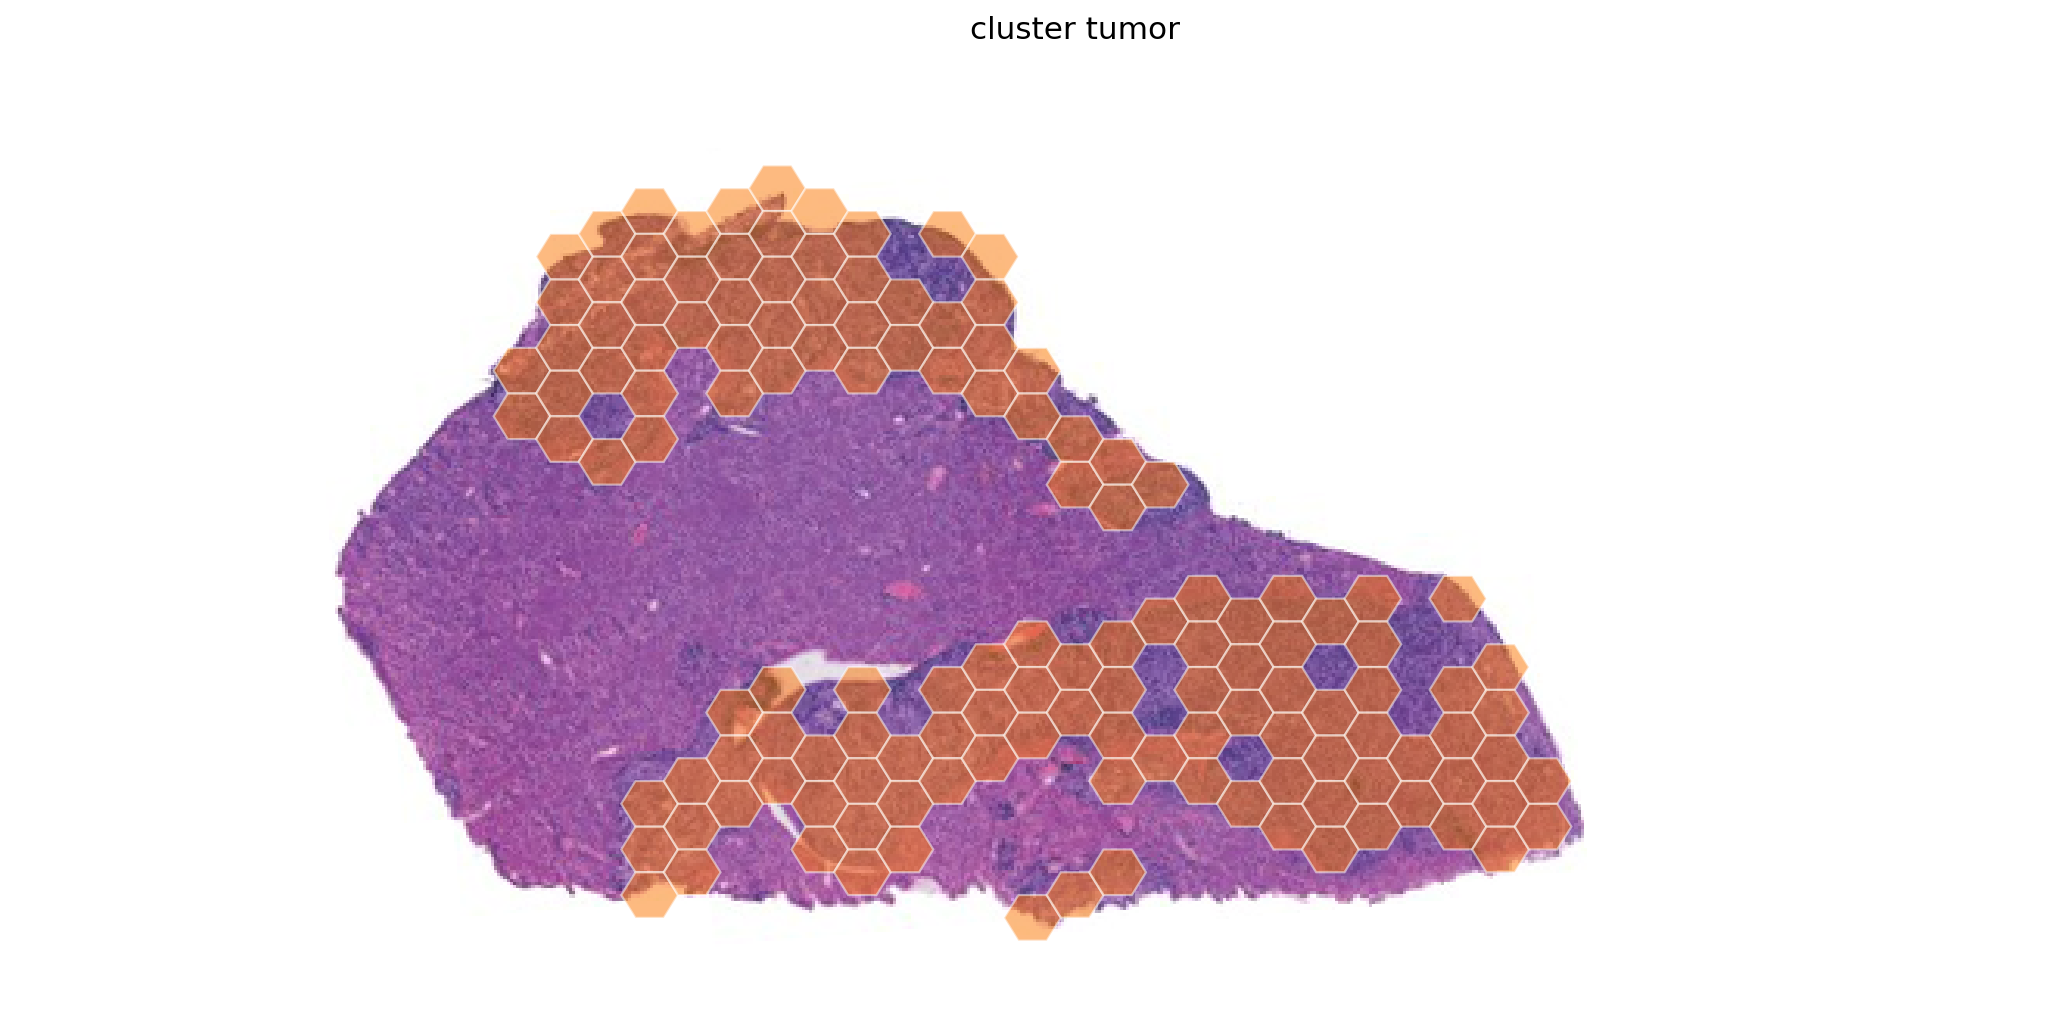

In [406]:
color_itorator=0



# fig, ax = plt.subplots()
# xy = [0.45, 0.52] #### XY positions!!

# arr_img = tr
# imagebox = OffsetImage(arr_img,zoom=1.5) #####Zoom!!
# ab = AnnotationBbox(imagebox, xy, frameon=False)
# ax.add_artist(ab)
# ax.axis('off')







for t in adata.obs.area_1.cat.categories:
#for t in ['tumor']:

    
    fig, ax = plt.subplots()
    xy = [0.43, 0.47] #### XY positions!!

    arr_img = tr
    imagebox = OffsetImage(arr_img,zoom=1.4) #####Zoom!!
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)
    ax.axis('off')









    df_=df[df['area_1'] == t]
    
    #sets cell counter
    df_['count']=1
    
    df__=df_.groupby('barcode', as_index=False)['count'].sum()

    map_array=spatial_map.merge(df__, on='barcode', how='left')
    
    map_array=map_array.fillna('0')
    map_array['count']=map_array['count'].astype(int)
    
    
    
    # max value for coloring
    max_val=max(map_array['count'])
    norm = mpl.colors.Normalize(vmin=0,vmax=max_val)
    
    custom_color=adata.uns['CellType_colors'][color_itorator]
    custom_map = mpl.colors.LinearSegmentedColormap.from_list("", ["#ffffff",custom_color])
    
    color_itorator = color_itorator+1
    
    
    
    
    #remove zero count wells
    map_array=map_array[map_array['count']!=0]
    
    
    count_hex=[]
    for i in map_array['count']:
        if i > cutoff:

        #    count_hex.append(mpl.colors.rgb2hex(custom_map(norm(i))[:3]))
            count_hex.append('#fc7703')
            
        else:
            count_hex.append('#ffffff')

    map_array['color']=count_hex
    
    for index, row in map_array.iterrows():
        if row['X'] % 2 != 0:
            row['Y']=row['Y']-0.5
    
        polygon = hexagon(row['X'],row['Y'],row['color'])
        
        
        
        plt.gca(zorder=2).add_patch(polygon)
    
  


    plt.ylim(19,-1) #flip y axis
    plt.xlim(-1,43)
    plt.rcParams['figure.figsize'] = [15, 7.5] 
    
    plt.ylabel('cell number')
    plt.title('cluster %s' %t) 
    plt.axis('off')
    
    
    plt.show()



In [391]:
map_array

barcode   X   Y  count    color
131  CTGTCGCGATACAAGC   8   6      6  #fc7703
132  CCTTGAGAACTTCAGA   8   7      5  #fc7703
147  CGGCATTACACCTTAC   9   4      6  #fc7703
148  GGCATAAGCTCAACTC   9   5      8  #fc7703
149  GGTTCCTAATAGACAC   9   6      7  #fc7703
150  TACCGTTCTCGAGCGT   9   7      3  #fc7703
151  TACTCACTGGCAACAT   9   8      6  #fc7703
164  CGACCATACTACTGTC  10   3      2  #fc7703
165  ATTGCACCGTGACAGC  10   4      5  #fc7703
166  GTCATGTGCTTCACGA  10   5      4  #fc7703
167  TTGAGGAACAGGATGA  10   6      2  #fc7703
169  GGTAACTGGCAGAGGT  10   8      2  #fc7703
182  AGTACCGGCAAGTTAA  11   3      1  #fc7703
183  TAATGGCGCAGAGACC  11   4      1  #fc7703
184  ATGGCAAGGTTCTATG  11   5      3  #fc7703
185  CAGGTCATGATATACG  11   6      2  #fc7703
186  GGTCACCACTTACAGT  11   7      8  #fc7703
187  CGAGGCTATGCGTTGG  11   8     10  #fc7703
195  CCTATCCTGGACTTGT  11  16     19  #fc7703
196  GCCTGTAGGTTCTAGC  11  17      9  #fc7703
197  GACCGTCTCATAGCGC  11  18      4  #fc7703
200  GTCACGTGTGGTCTCG  12   3     13  #fc7703
201  CATGACCAGAGGCACG  12   4     14  #fc7703
202  CCAGGAGATAGGCGCA  12   5      3  #fc7703
212  TATAAGCCGACGACGC  12  15     13  #fc7703
213  TCTTGTCGAGACCAAC  12  16     41  #fc7703
214  AGGTTCGAGTTAGAGT  12  17      4  #fc7703
218  GTCGATTGTCACTGCA  13   3      3  #fc7703
219  GAAGACATCTAAGTGG  13   4      2  #fc7703
220  CGGATATCCACCTATA  13   5      6  #fc7703
..                ...  ..  ..    ...      ...
461  GGCCAATCACGAAGCC  26  12     39  #fc7703
462  GGCTCAACTGCTATTC  26  13     14  #fc7703
463  CCAGTCATAATGACGA  26  14     26  #fc7703
464  TCCACTGGAGTGTCGC  26  15     28  #fc7703
465  CTAACCGAGCAATGTT  26  16      4  #fc7703
479  CGTAAGCGACCTAGTG  27  12      3  #fc7703
481  AGCTCTACTCAATCCA  27  14      1  #fc7703
482  CTTCCTATCTTACGGT  27  15      4  #fc7703
483  ATCACGCGTCAGCTCA  27  16      1  #fc7703
484  CGGAGGCAGGATTGGA  27  17      1  #fc7703
496  TTAGTTGTTCCTGGCC  28  11     21  #fc7703
497  TCCTCAAGCAAGCACT  28  12     23  #fc7703
498  GAGTGTCTGCGGAGAT  28  13      6  #fc7703
499  CGGATCGCTTGTCTTA  28  14      6  #fc7703
500  CTACCGACATCCTAGC  28  15     11  #fc7703
501  GTGCTCGTTAGGTTCT  28  16     38  #fc7703
518  AGAGCCAAGGAGGTCG  29  15      1  #fc7703
519  CGATAGCCTTATTGCT  29  16     22  #fc7703
532  CCAGACTAGAATGCGT  30  11      3  #fc7703
534  CCGTTAACTGCTCAGT  30  13      2  #fc7703
535  CGATGAACCGGTCCAT  30  14     19  #fc7703
536  GCAGTCATGAATCGTT  30  15     17  #fc7703
537  CGAGTGAGGAGAGCAT  30  16      9  #fc7703
552  AGGACGAACTCGCCGA  31  13     13  #fc7703
553  TAGTACGCCAACTGTT  31  14      5  #fc7703
554  GCTACTCGTGCTAGTC  31  15      8  #fc7703
555  TCTCATCTGAGTGGCG  31  16      5  #fc7703
556  TATGCAGGTTCACTGT  31  17     17  #fc7703
572  GGTAGAACTCGGCACA  32  15      1  #fc7703
573  GAAGTGTTCGACATCA  32  16      4  #fc7703

[138 rows x 5 columns]

In [300]:
from skimage import data, color


In [301]:
from skimage.transform import rescale, resize, downscale_local_mean

In [335]:
image = rescale(tr, 1.4, anti_aliasing=True)

In [336]:
image

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

Text(0.5, 1.0, 'Original image')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


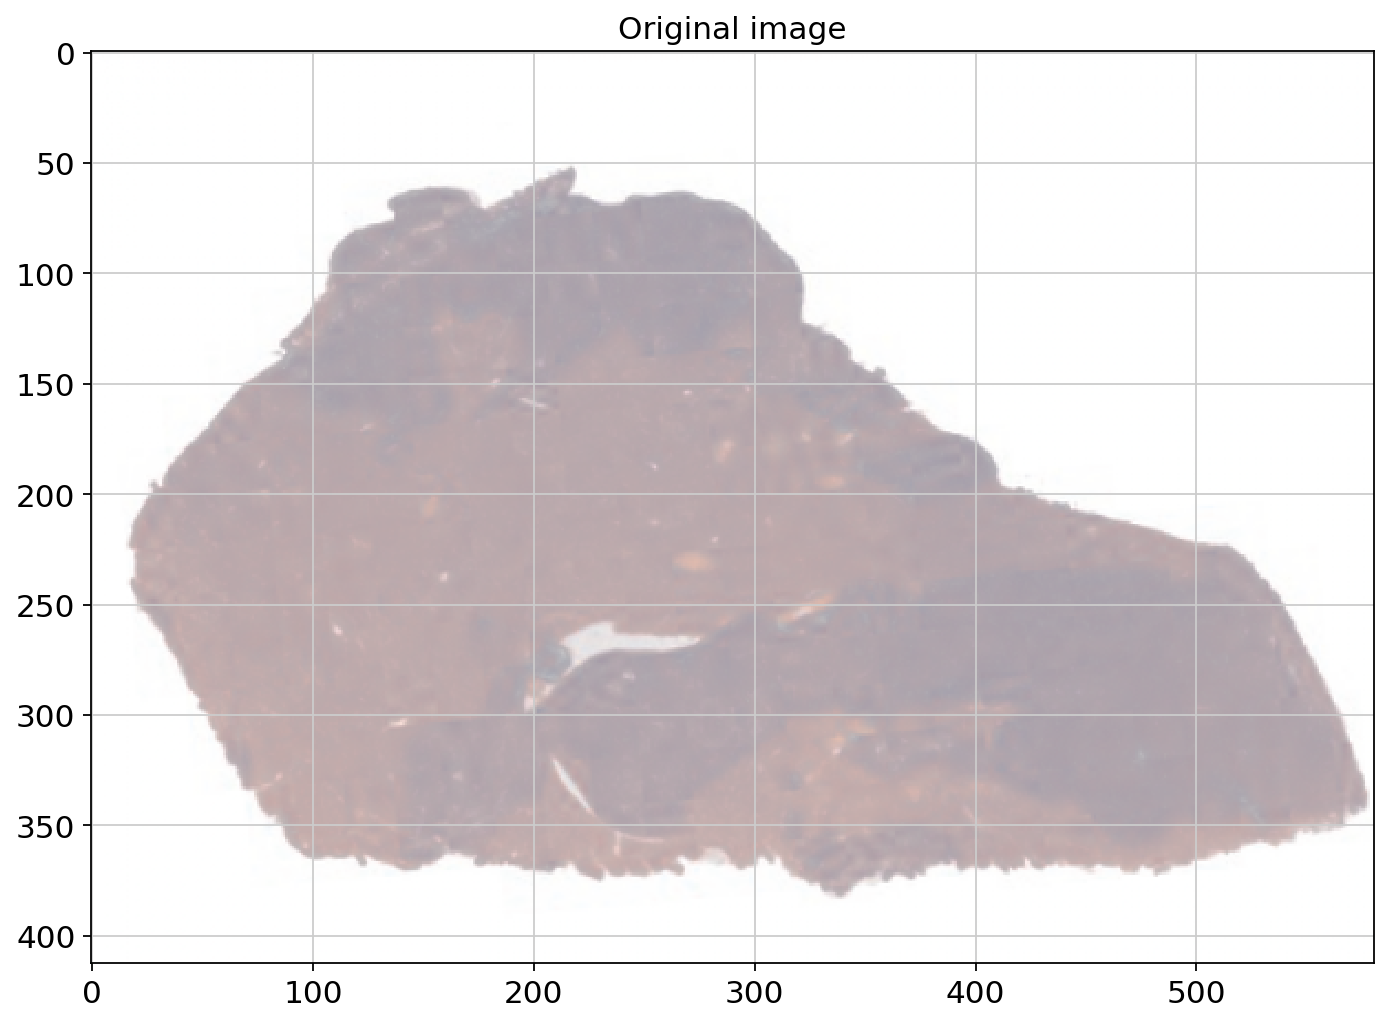

In [338]:
fig, axes = plt.subplots()

ax = axes

ax.imshow(image)
ax.set_title("Original image")


In [136]:
test=pd.read_csv("../../../XYZeq/L20C1_tumor_wells.csv")



In [145]:
test['x']=test['x']*10

In [151]:
test['y']=250-test['y']

In [148]:
test['y']=test['y']*15

In [150]:
test

x    y
0     80  195
1     80  180
2     80  165
3     90  210
4     90  195
5     90  180
6     90  165
7     90  150
8    100  225
9    100  210
10   100  195
11   100  180
12   100  165
13   100  150
14   110  225
15   110  210
16   110  195
17   110  180
18   110  165
19   110  150
20   110   30
21   110   15
22   110    0
23   120  225
24   120  210
25   120  195
26   120   45
27   120   30
28   120   15
29   130  225
..   ...  ...
126  270   75
127  270   60
128  270   45
129  270   30
130  270   15
131  280  105
132  280   90
133  280   75
134  280   60
135  280   45
136  280   30
137  290   90
138  290   75
139  290   60
140  290   45
141  290   30
142  300  105
143  300   90
144  300   75
145  300   60
146  300   45
147  300   30
148  310   75
149  310   60
150  310   45
151  310   30
152  310   15
153  320   60
154  320   45
155  320   30

[156 rows x 2 columns]

In [271]:
adata

AnnData object with n_obs × n_vars = 4788 × 789 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'leiden', 'louvain', 'CellType', 'barcode', 'area_1'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'louvain', 'leiden_colors', 'CellType_colors', 'area_1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


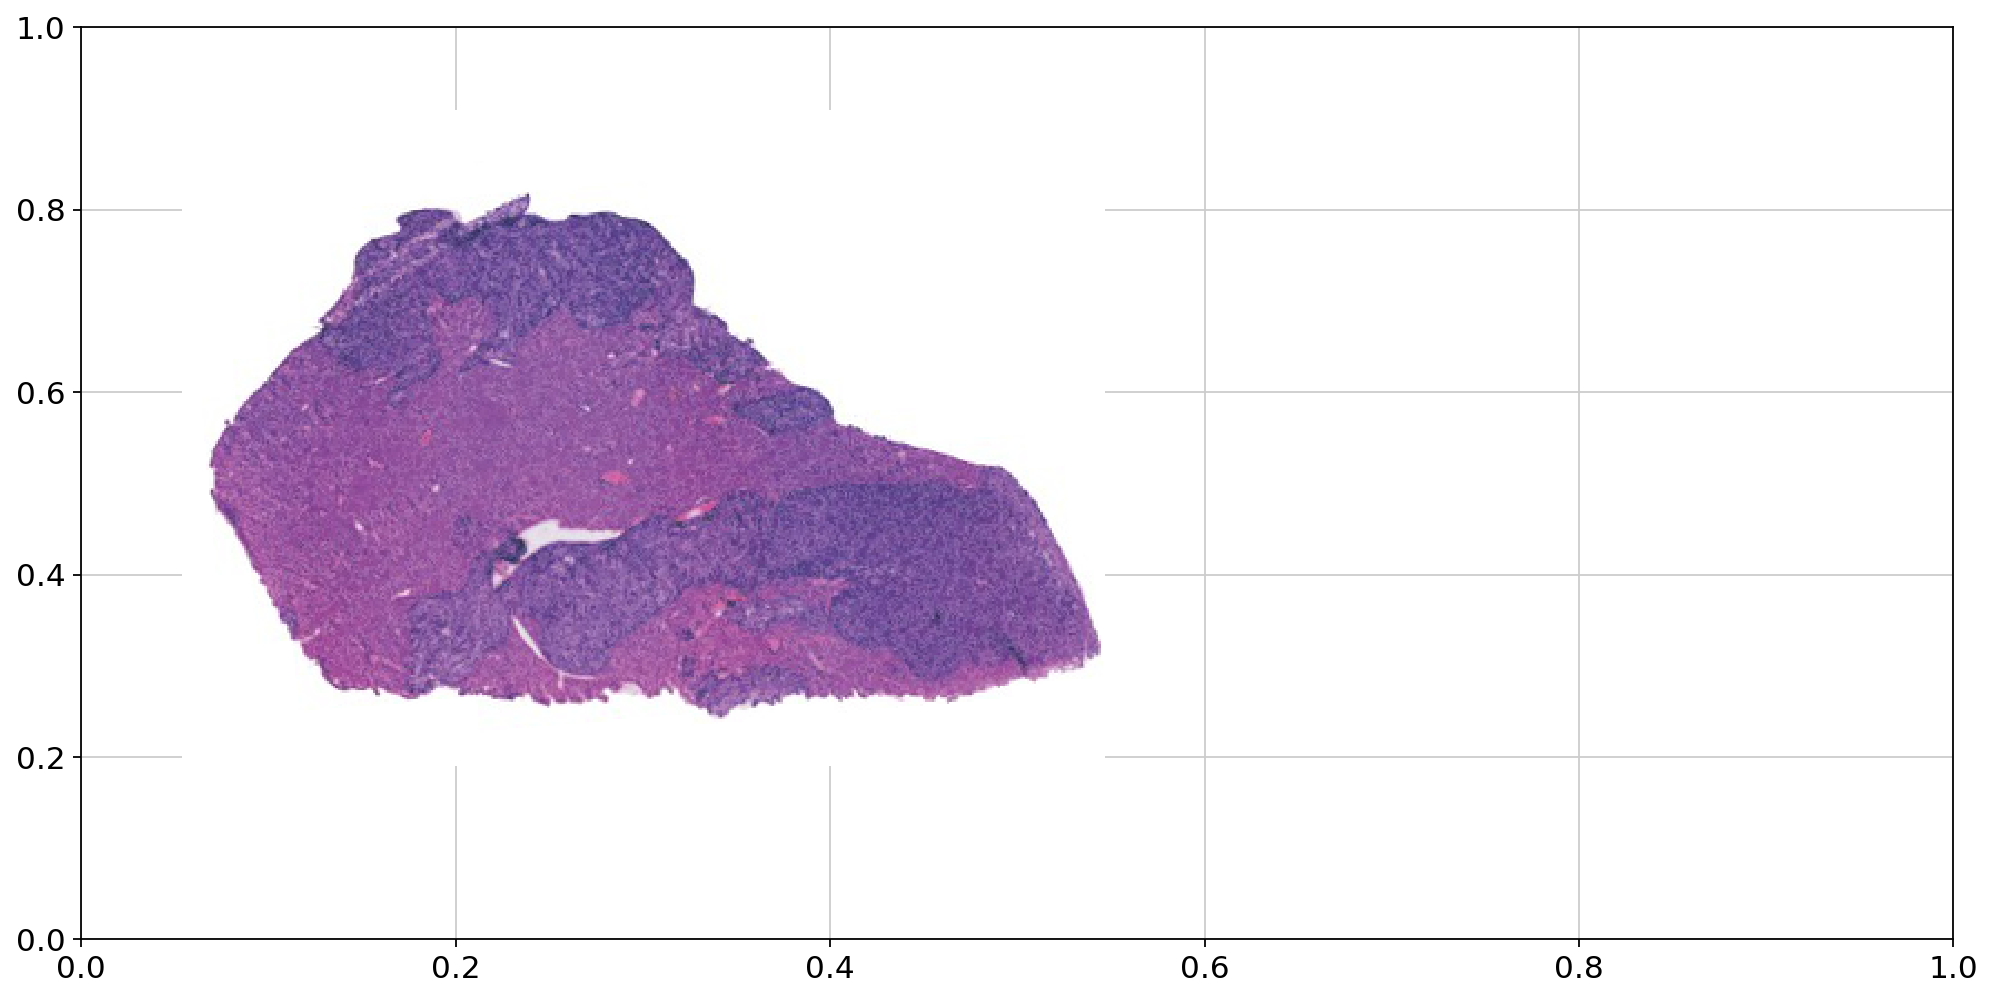

In [363]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data


fig, ax = plt.subplots()
xy = [0.3, 0.55] #### XY positions!!

arr_img = tr
imagebox = OffsetImage(arr_img,zoom=1) #####Zoom!!
ab = AnnotationBbox(imagebox, xy, frameon=False)
ax.add_artist(ab)



ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()